In [1]:
%load_ext autoreload
%autoreload 2
exec(open("init_notebook.py", "r").read())

current working dirC:\Users\abjawad\Documents\Github\cogmod-driver-behavior-model


In [2]:
import pandas as pd
from analysis.Plot import Plot
from lib.HighD import HighD
from lib.Filter import Filter
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

In [18]:
data_path = r"C:/Users/abjawad/Documents/GitHub/cogmod-driver-behavior-model/logs/Research_IDM1_COG2_DATA.csv"
# read file 
simulated_df = pd.read_csv(data_path)
simulated_df.head()

dataset_id  scenario_id  exec_num agent_type  frame      scenario_status  \
0           1            0         0        idm   5449  ScenarioState.START   
1           1            0         0        idm   5450  ScenarioState.START   
2           1            0         0        idm   5451  ScenarioState.START   
3           1            0         0        idm   5452  ScenarioState.START   
4           1            0         0        idm   5453  ScenarioState.START   

   ego_id         c_x       c_y    c_speed  ...  c_throttle  c_brake  \
0      50 -192.590744  2.862465  40.351349  ...         0.0      0.0   
1      50 -190.976364  2.851502  40.351349  ...         0.0      0.0   
2      50 -189.361984  2.840538  40.351349  ...         0.0      0.0   
3      50 -187.747620  2.829574  40.351349  ...         0.0      0.0   
4      50 -186.133240  2.818610  40.351349  ...         0.0      0.5   

   perceived_c_x  perceived_c_y  perceived_c_speed        gaze_direction  \
0            0.0            0.0                0.0  GazeDirection.CENTER   
1            0.0            0.0                0.0  GazeDirection.CENTER   
2            0.0            0.0                0.0  GazeDirection.CENTER   
3            0.0            0.0                0.0  GazeDirection.CENTER   
4            0.0            0.0                0.0  GazeDirection.CENTER   

   preceding_id        a_x   a_y   a_speed  
0            47  67.464996  0.96  39.55006  
1            47  67.464996  0.96  39.55006  
2            47  67.464996  0.96  39.55006  
3            47  67.464996  0.96  39.55006  
4            47  67.464996  0.96  39.55006  

[5 rows x 23 columns]

In [19]:
# remove scenario id 2 
scenario_id = 0
idm_df = simulated_df[(simulated_df["scenario_id"] == scenario_id) & (simulated_df["agent_type"] == 'idm')]
print(idm_df.exec_num.unique()) 

cogmod_df = simulated_df[(simulated_df["scenario_id"] == scenario_id) & (simulated_df["agent_type"] == 'cogmod')]
print(cogmod_df.exec_num.unique())

# cogmod_df['c_speed'] = savgol_filter(cogmod_df['c_speed'], 51, 3)

[0]
[1]


In [20]:
def get_best_exec_num(df):
    df = df.copy()  # Create a copy of the DataFrame
    distance = np.sqrt((df['c_x'] - df['a_x'])**2 + (df['c_y'] - df['a_y'])**2)
    relative_speed = df['c_speed'] - df['a_speed']
    relative_speed = np.where(relative_speed != 0, relative_speed, 1e-6)
    
    thw = distance / df['c_speed']
    ttc = distance / relative_speed
    
    df['thw'] = thw 
    df['ttc'] = ttc
    
    best_exec_thw = df[df['thw'] == thw.min()]['exec_num'].values[0]
    best_exec_ttc = df[df['ttc'] == ttc.min()]['exec_num'].values[0]

    print('best exec thw ', best_exec_thw, ' best exec ttc ', best_exec_ttc)
    pass

get_best_exec_num(cogmod_df)


best exec thw  1  best exec ttc  1


In [21]:
HighD_path = r'D:\\highD_data\\highD_dataset'
ids = ["01"]
highD = HighD(ids, HighD_path)

dataset_id = 1
_, tMeta, tracks = highD.get_dataframe_tuple(dataset_id)
df = highD.get_combined_dataframe(dataset_id)
image = highD.get_image(dataset_id)
df.head()

follow_meta = Filter.filter_vehicle_follow_scenario(df, 
                                      ego_type='Car', 
                                      preceding_type='Car',
                                      minDuration=5, 
                                      minStartDistance=50,
                                      maxStartDistance=100,
                                      removeStrictDistanceInc=True)

print(follow_meta.shape)
follow_meta.head()
print('scenario id ', scenario_id)
scenario_follow_meta = follow_meta.iloc[scenario_id]
ego_id = int(scenario_follow_meta['ego_id'])
preceding_id = int(scenario_follow_meta['preceding_id'])
start_frame = int(scenario_follow_meta['start_frame'])
end_frame = int(scenario_follow_meta['end_frame'])
print(ego_id, preceding_id, start_frame, end_frame)
print('total frmae ', end_frame - start_frame)

original_df = df.loc[(df['id'] == ego_id) & (df['frame'] >= start_frame) & (df['frame'] < end_frame)]

Loaded data and image for dataset 01.
Filtering vehicle follow scenario Car Car 5 50 100
total actors 1047, filtered actors 730, ratio 0.6972301814708691
total actors 1047, filtered actors 730, ratio 0.6972301814708691
total scenario 10, filtered scenario 5, ratio 0.5
(5, 9)
scenario id  0
50 47 994 1211
total frmae  217


In [24]:
cogmod = cogmod_df[(cogmod_df["exec_num"] == 1) &(cogmod_df["scenario_status"] == "ScenarioState.RUNNING")]
idm = idm_df[idm_df['scenario_status'] == "ScenarioState.RUNNING"]


def TTC(df):
    df = df.copy()  # Create a copy of the DataFrame
    distance = np.sqrt((df['c_x'] - df['a_x'])**2 + (df['c_y'] - df['a_y'])**2)
    relative_speed = df['c_speed'] - df['a_speed']
    relative_speed = np.where(relative_speed != 0, relative_speed, 1e-6)
    ttc = distance / relative_speed
    df['ttc'] = ttc
    return df

def THW(df):
    df = df.copy()  # Create a copy of the DataFrame
    distance = np.sqrt((df['c_x'] - df['a_x'])**2 + (df['c_y'] - df['a_y'])**2)
    thw = distance / df['c_speed']
    df['thw'] = thw
    return df

idm = TTC(idm)
idm = THW(idm)
cogmod = TTC(cogmod)
cogmod = THW(cogmod)

In [25]:
print(original_df.shape)
print(idm.shape)
print(cogmod.shape)

print('original df col ', original_df.columns)
print('idm df col ', idm.columns)
print('cogmod df col ', cogmod.columns)

(217, 29)
(218, 25)
(218, 25)
original df col  Index(['dataset_id', 'locationId', 'frame', 'id', 'class', 'drivingDirection',
       'laneId', 'x', 'y', 'width', 'height', 'xVelocity', 'yVelocity',
       'xAcceleration', 'yAcceleration', 'frontSightDistance',
       'backSightDistance', 'dhw', 'thw', 'ttc', 'precedingXVelocity',
       'precedingId', 'followingId', 'leftPrecedingId', 'leftAlongsideId',
       'leftFollowingId', 'rightPrecedingId', 'rightAlongsideId',
       'rightFollowingId'],
      dtype='object')
idm df col  Index(['dataset_id', 'scenario_id', 'exec_num', 'agent_type', 'frame',
       'scenario_status', 'ego_id', 'c_x', 'c_y', 'c_speed', 'c_acceleration',
       'target_speed', 'c_steer', 'c_throttle', 'c_brake', 'perceived_c_x',
       'perceived_c_y', 'perceived_c_speed', 'gaze_direction', 'preceding_id',
       'a_x', 'a_y', 'a_speed', 'ttc', 'thw'],
      dtype='object')
cogmod df col  Index(['dataset_id', 'scenario_id', 'exec_num', 'agent_type', 'frame',
     

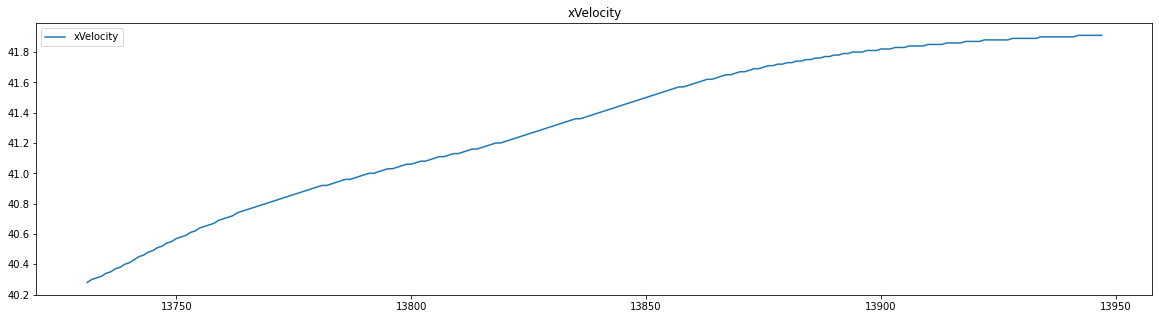

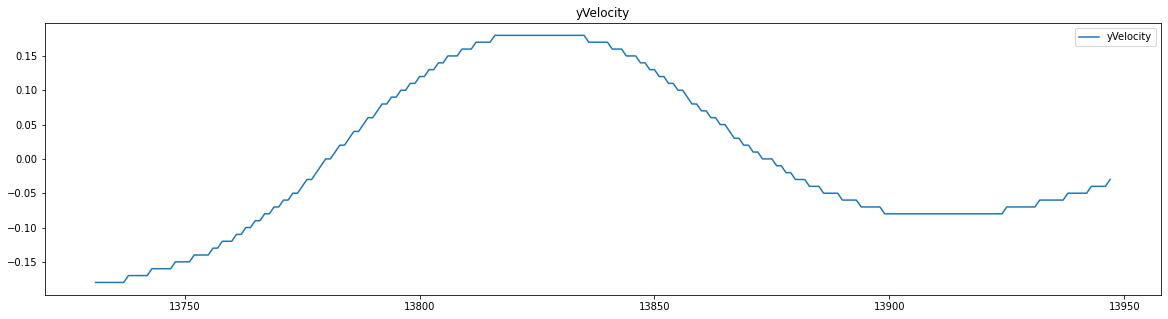

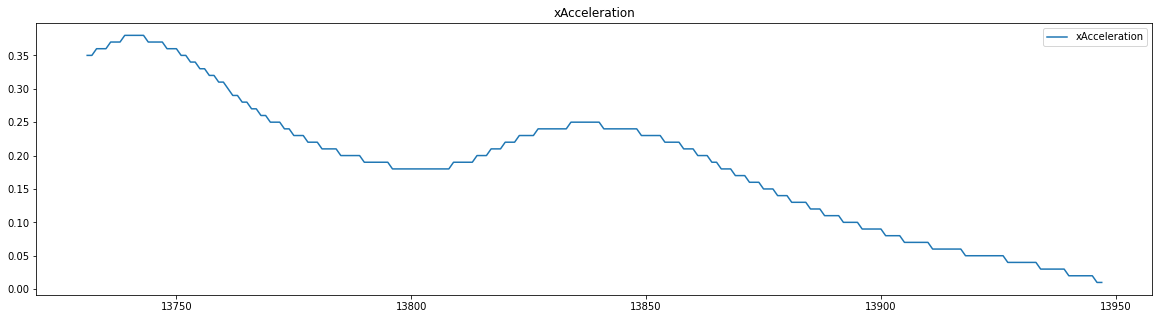

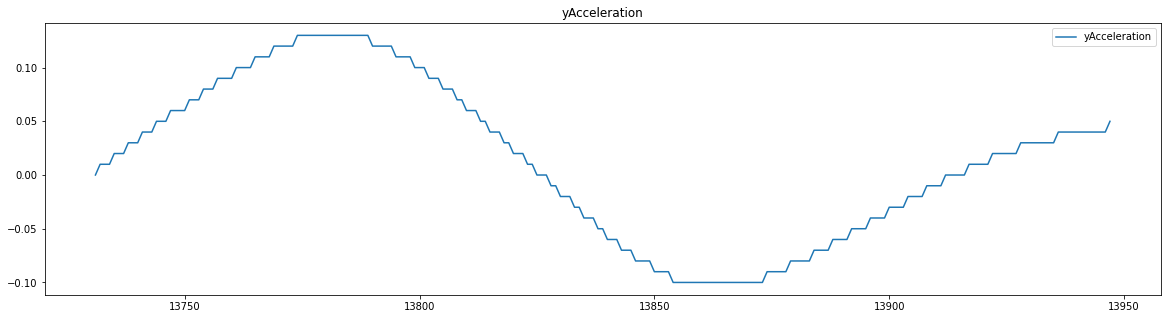

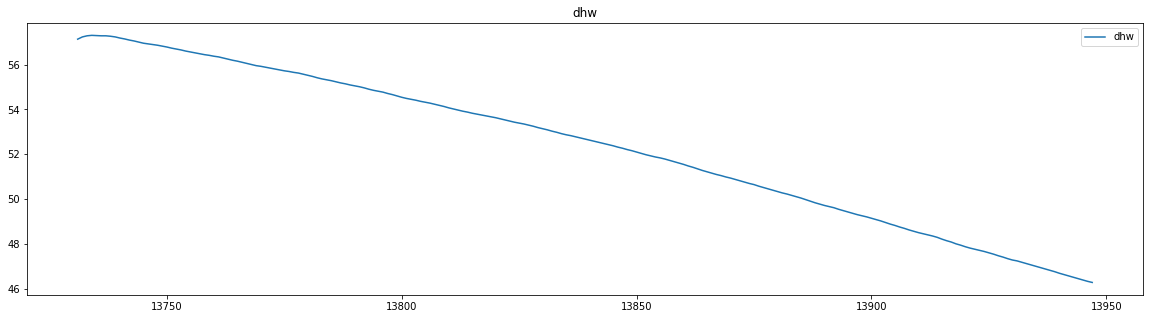

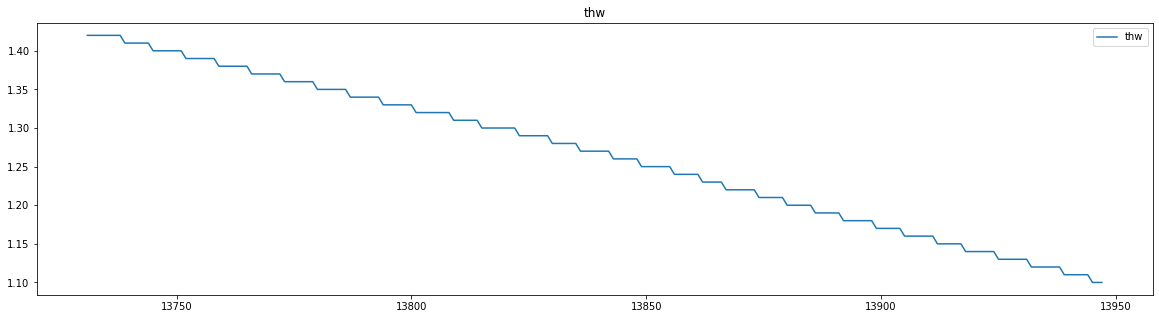

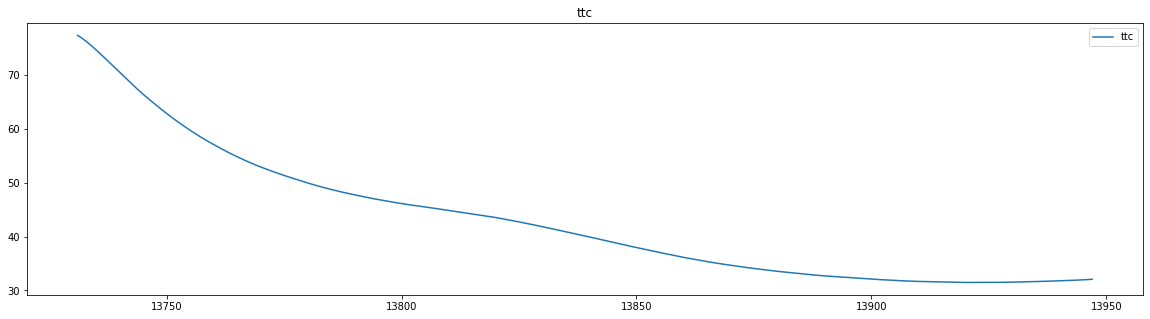

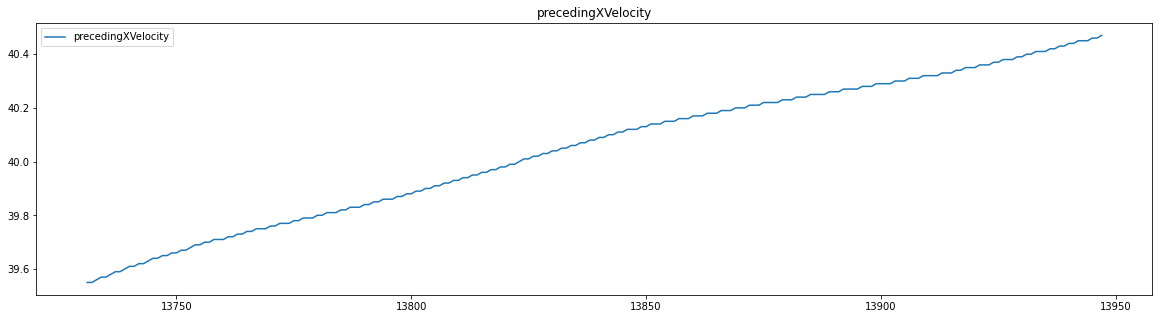

In [26]:
new_original_df = original_df[['xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration', 'dhw', 'thw', 'ttc', 'precedingXVelocity']]
for col in new_original_df.columns:
    new_original_df.plot(y=col, figsize=(20, 5), title=col)

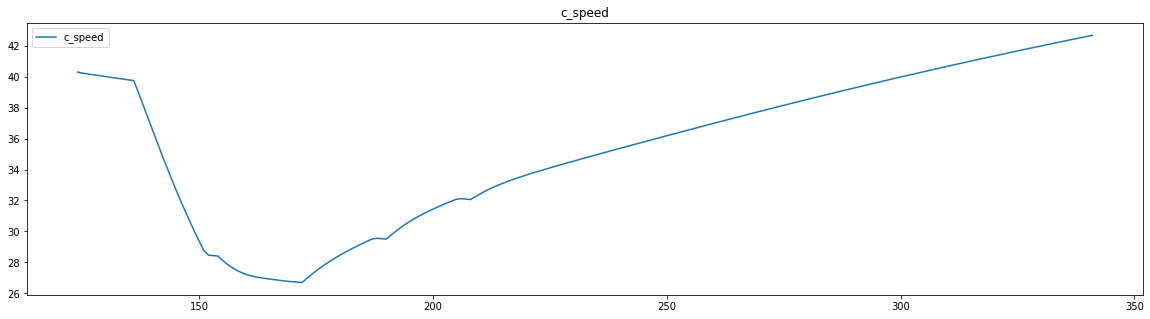

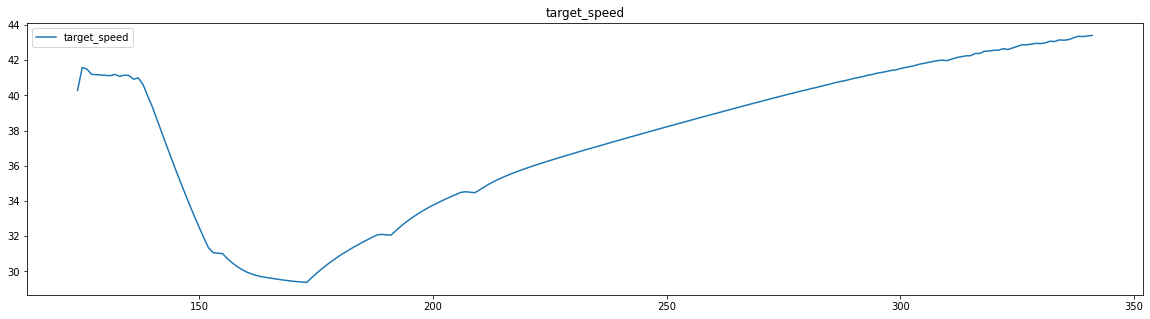

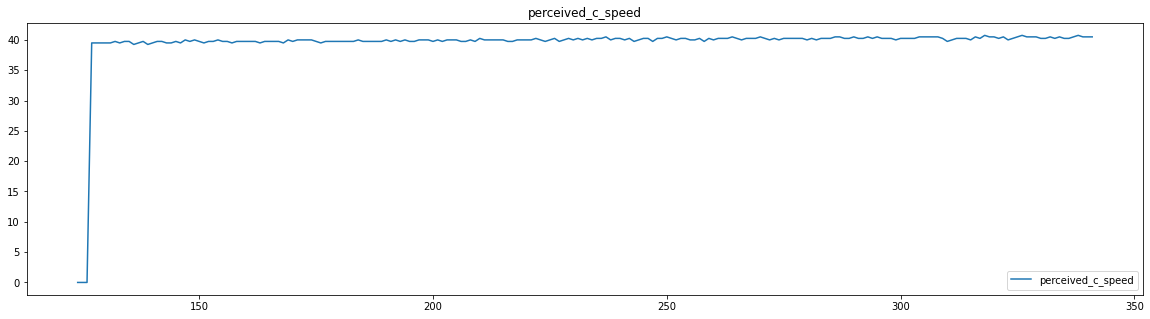

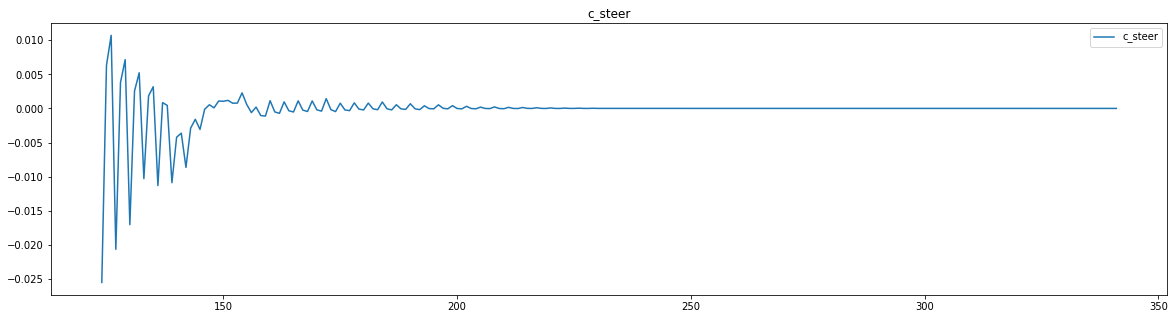

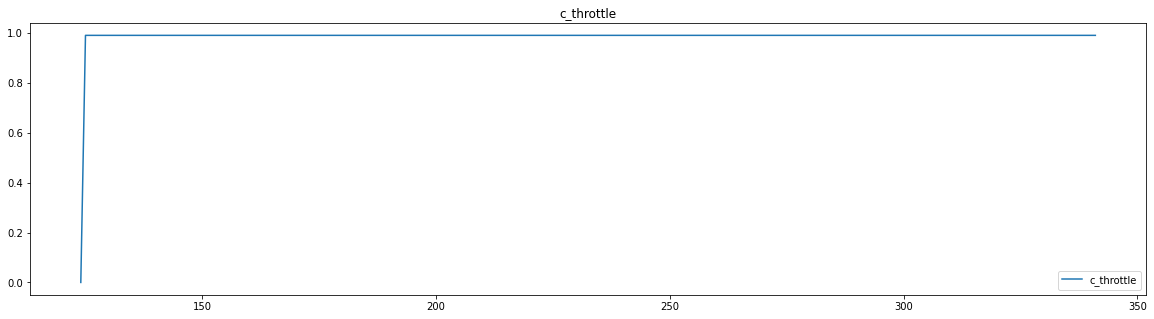

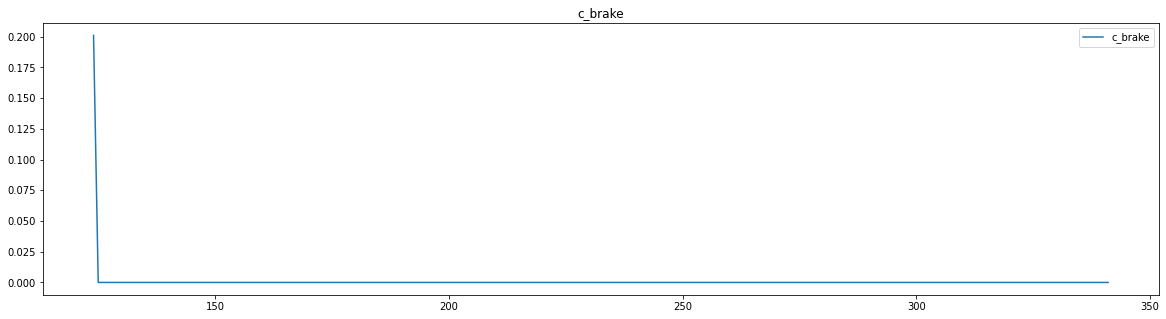

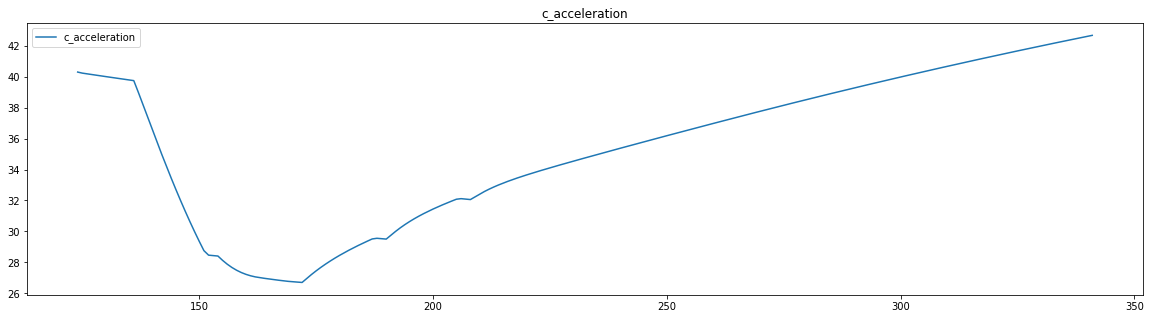

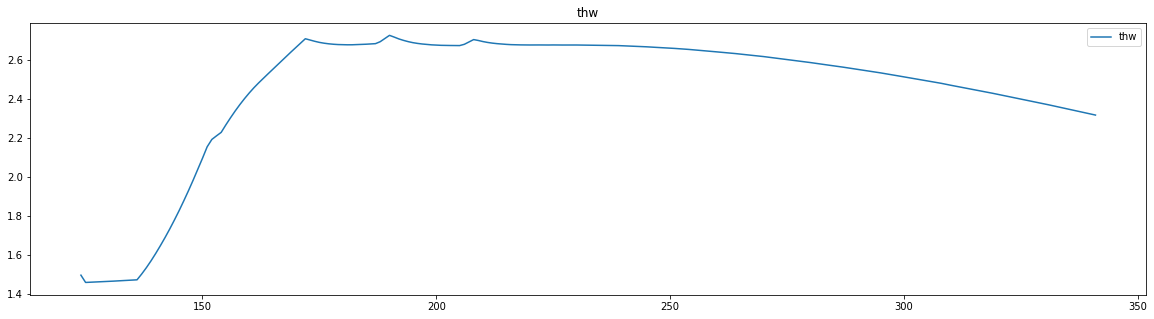

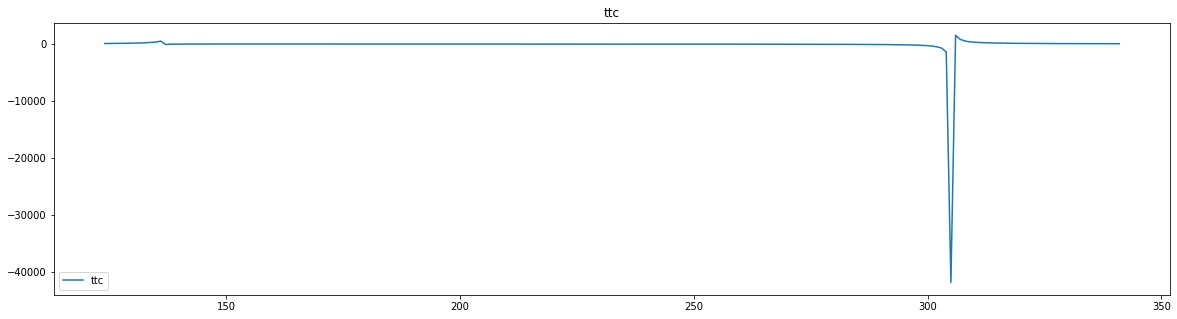

In [27]:
# Index(['dataset_id', 'scenario_id', 'exec_num', 'agent_type', 'frame',
    #    'scenario_status', 'ego_id', 'c_x', 'c_y', 'c_speed', 'c_acceleration',
    #    'target_speed', 'c_steer', 'c_throttle', 'c_brake', 'perceived_c_x',
    #    'perceived_c_y', 'perceived_c_speed', 'gaze_direction', 'preceding_id',
    #    'a_x', 'a_y', 'a_speed', 'thw', 'ttc'],
    #   dtype='object')
    
new_idm_df = idm[['c_speed', 'target_speed', 'perceived_c_speed', \
    'c_steer', 'c_throttle', 'c_brake', \
        'c_acceleration','thw', 'ttc']]
for col in new_idm_df.columns:
    new_idm_df.plot(y=col, figsize=(20, 5), title=col)


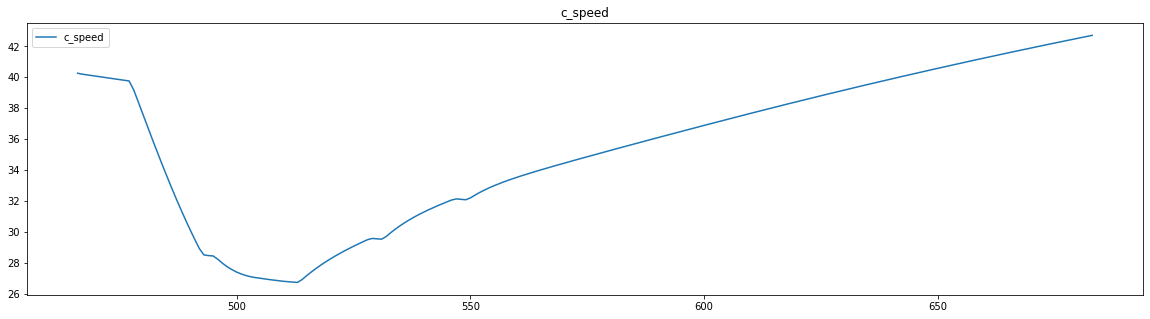

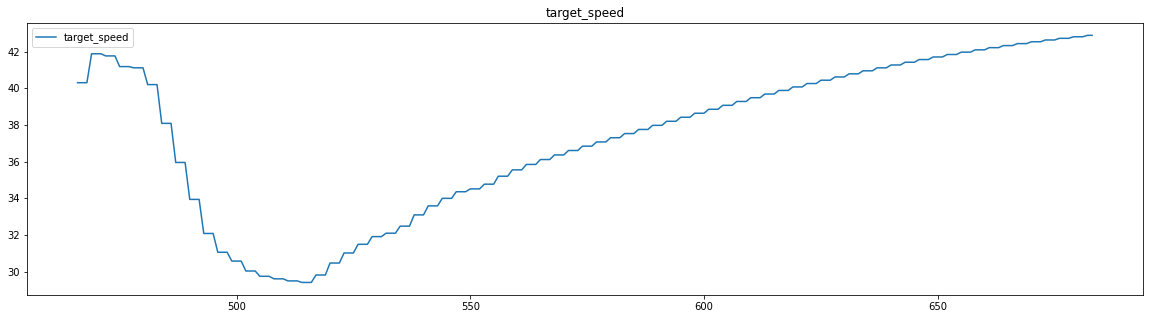

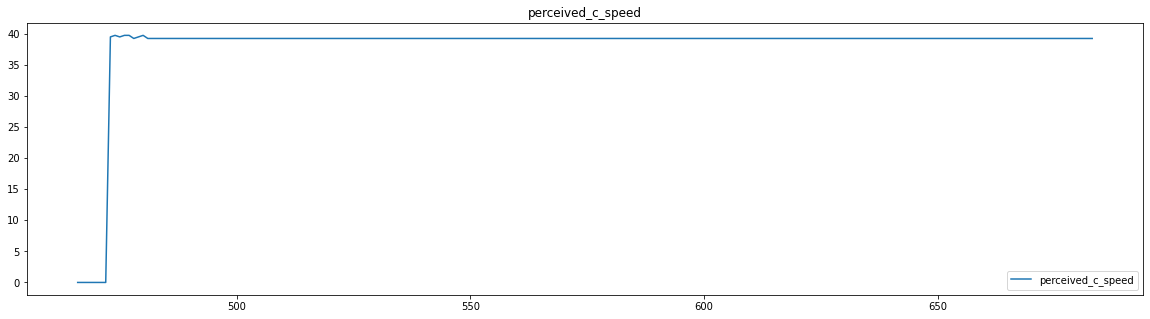

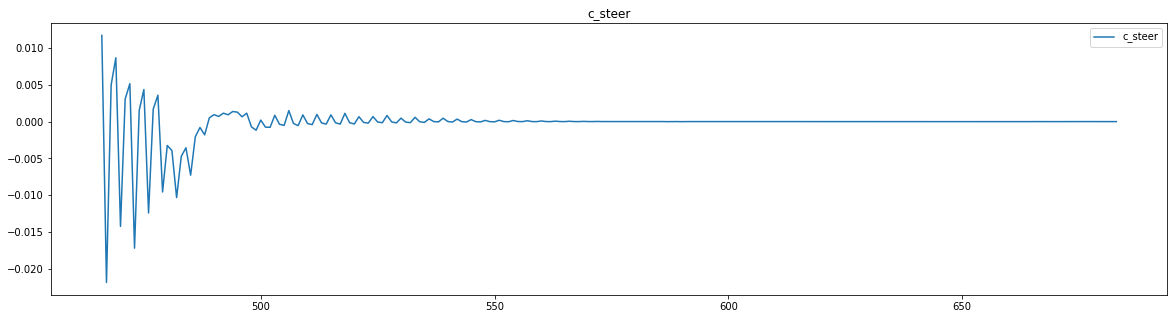

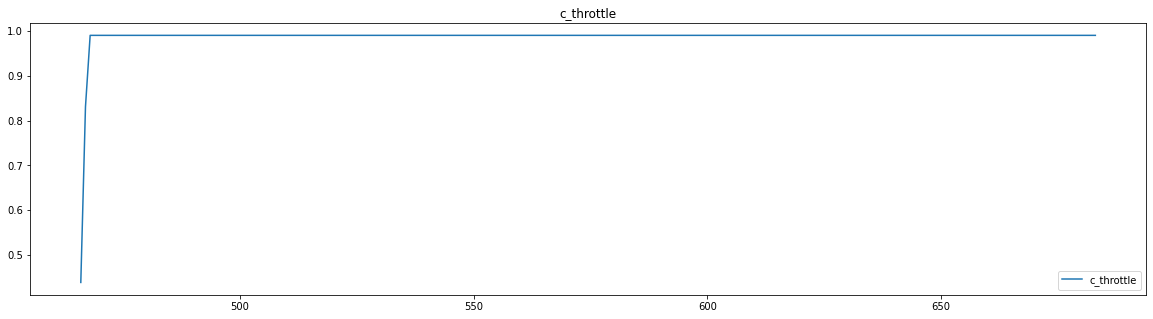

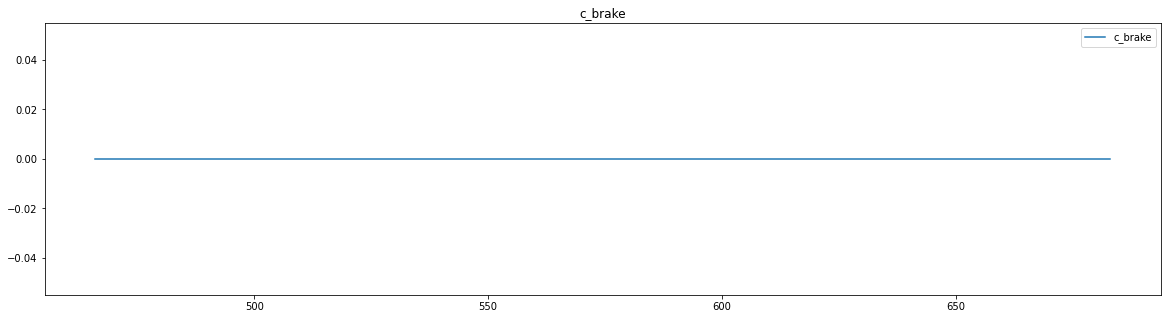

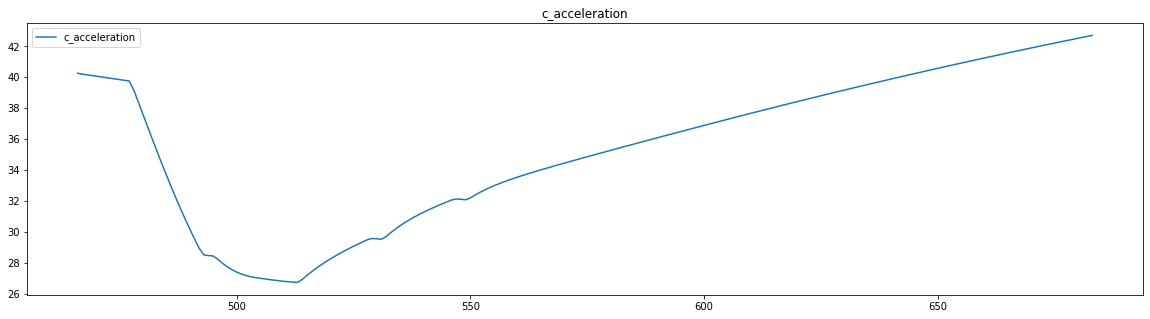

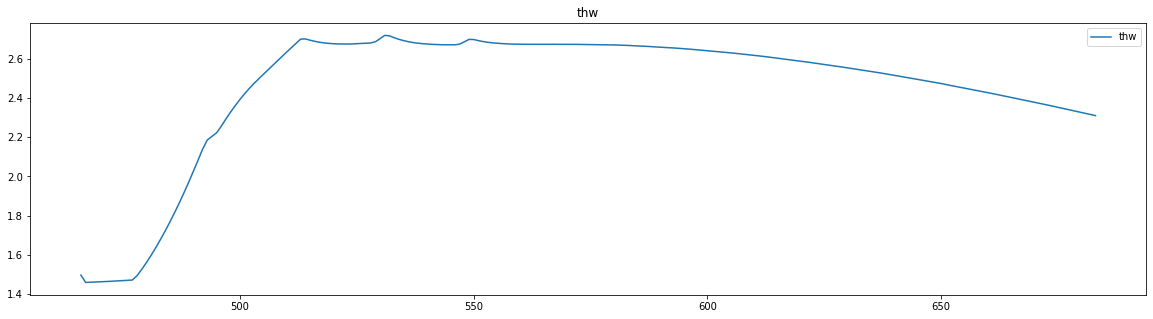

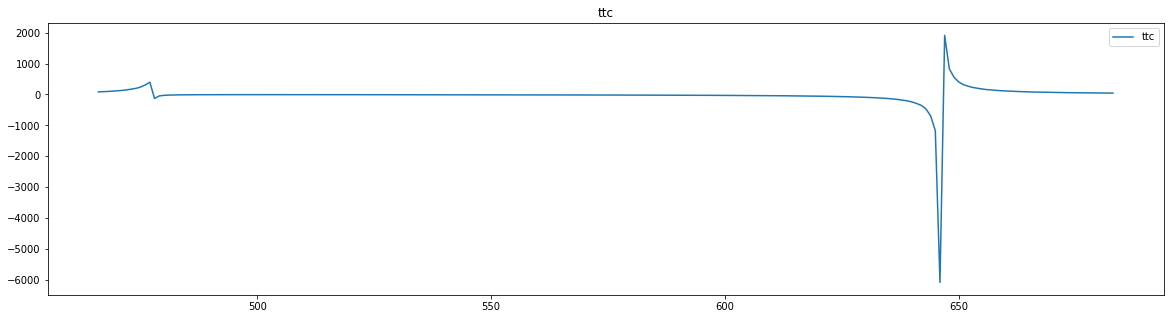

In [28]:
new_cogmod_df = cogmod[['c_speed', 'target_speed', 'perceived_c_speed', \
    'c_steer', 'c_throttle', 'c_brake', \
        'c_acceleration','thw', 'ttc']]
for col in new_cogmod_df.columns:
    new_cogmod_df.plot(y=col, figsize=(20, 5), title=col)

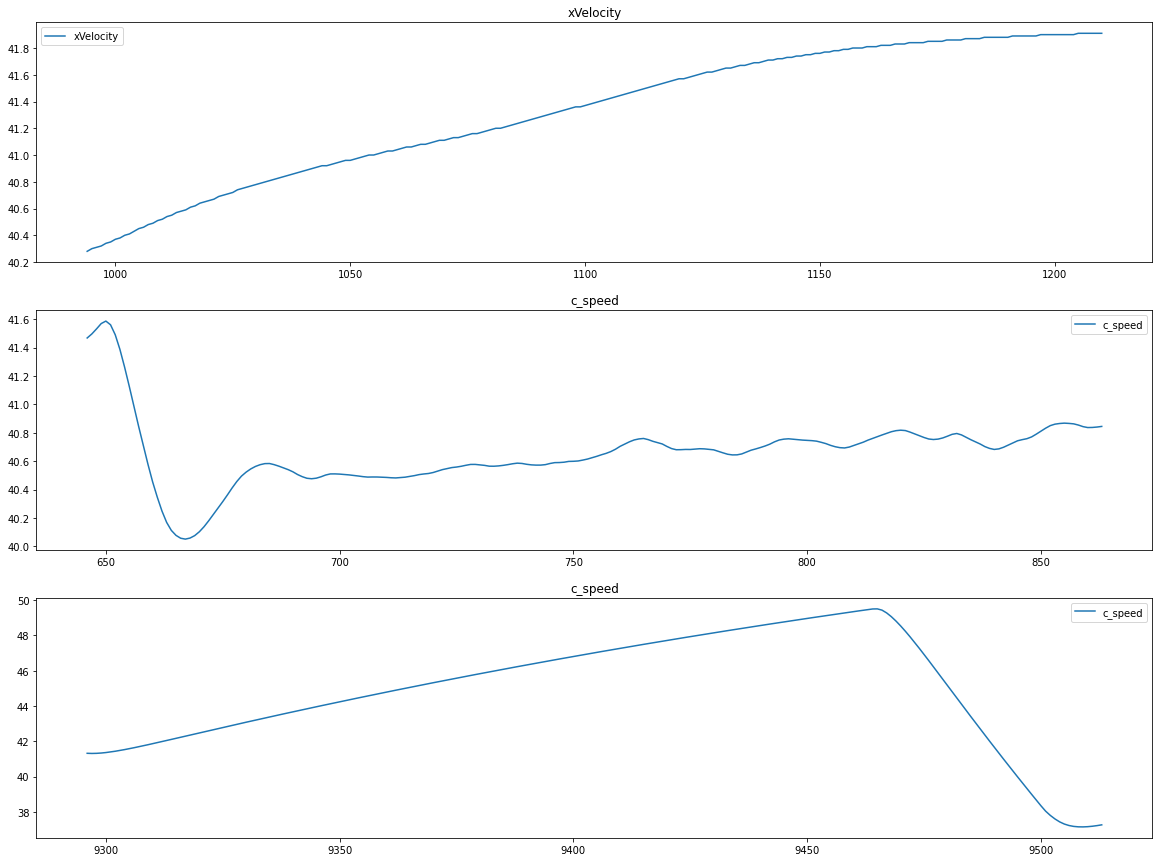

In [12]:
def plot_to_compare(original_df, col1, idm, col2, cogmod, col3):
    fig, ax = plt.subplots(3, 1, figsize=(20, 15))
    
    ax[0].plot(original_df['frame'], original_df[col1], label=col1)
    ax[0].set_title(col1)
    ax[0].legend()
    
    ax[1].plot(idm['frame'], idm[col2], label=col2)
    ax[1].set_title(col2)
    ax[1].legend()
    
    ax[2].plot(cogmod['frame'], cogmod[col3], label=col3)
    ax[2].set_title(col3)
    ax[2].legend()
    
    plt.show()

plot_to_compare(original_df, 'xVelocity', idm, 'c_speed', cogmod, 'c_speed')


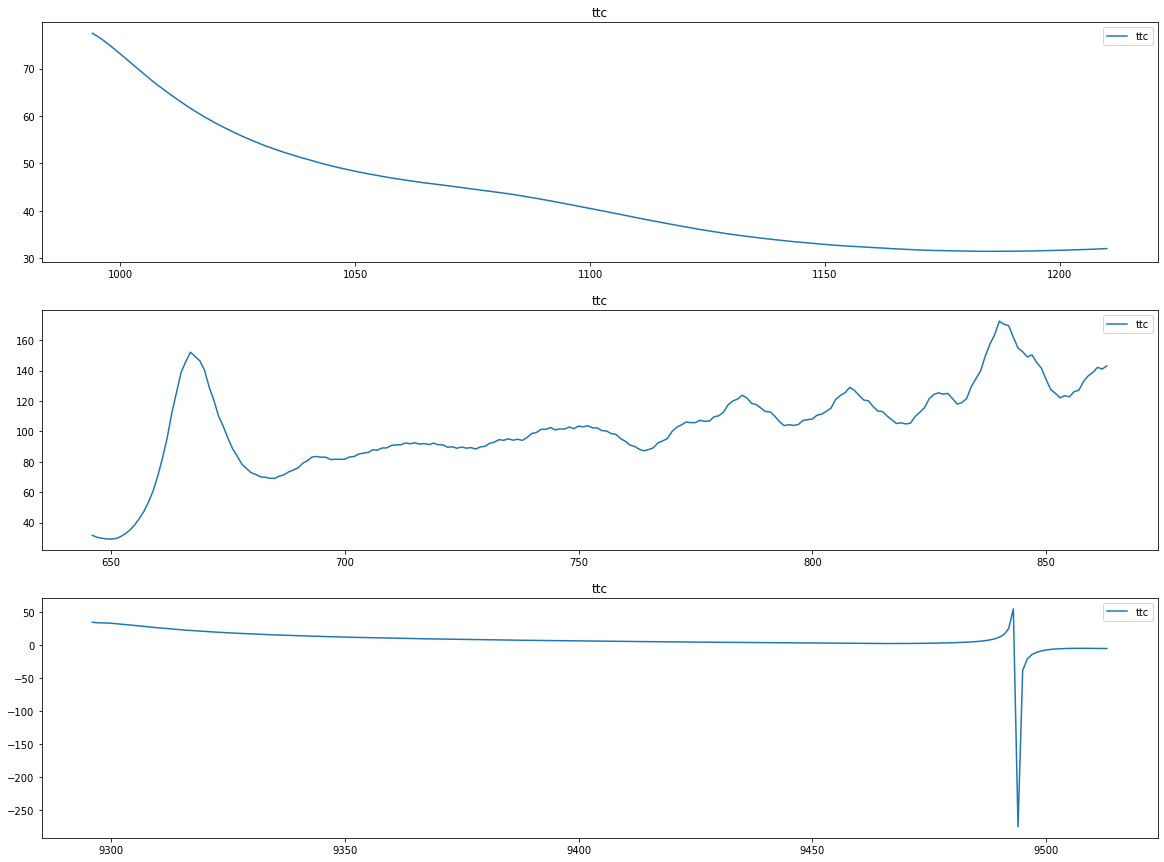

In [13]:
plot_to_compare(original_df, 'ttc', idm, 'ttc', cogmod, 'ttc')

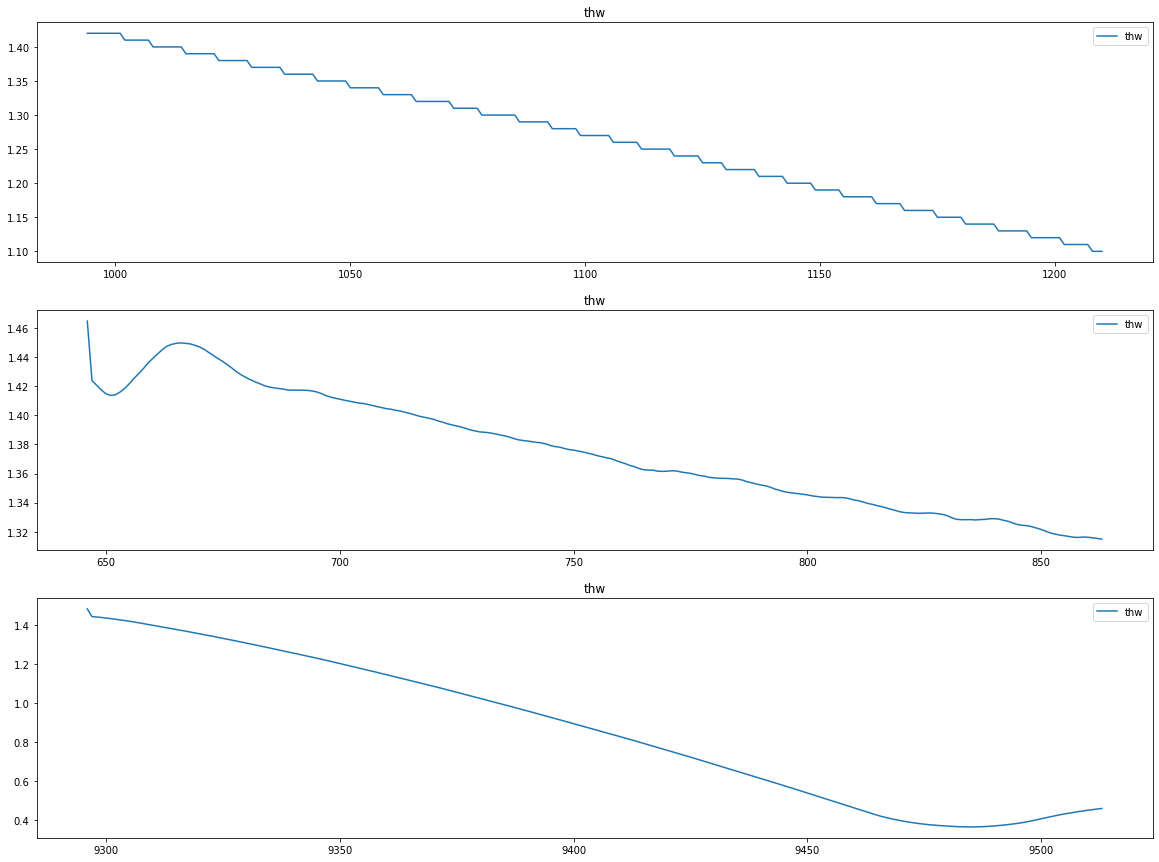

In [14]:
plot_to_compare(original_df, 'thw', idm, 'thw', cogmod, 'thw')

<AxesSubplot:xlabel='frame'>

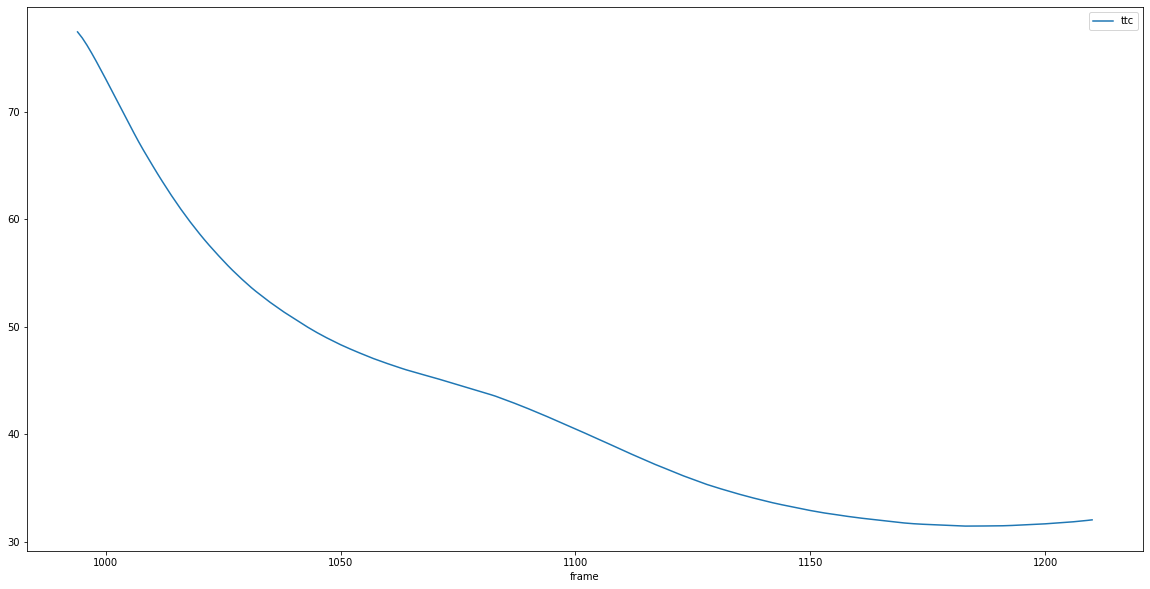

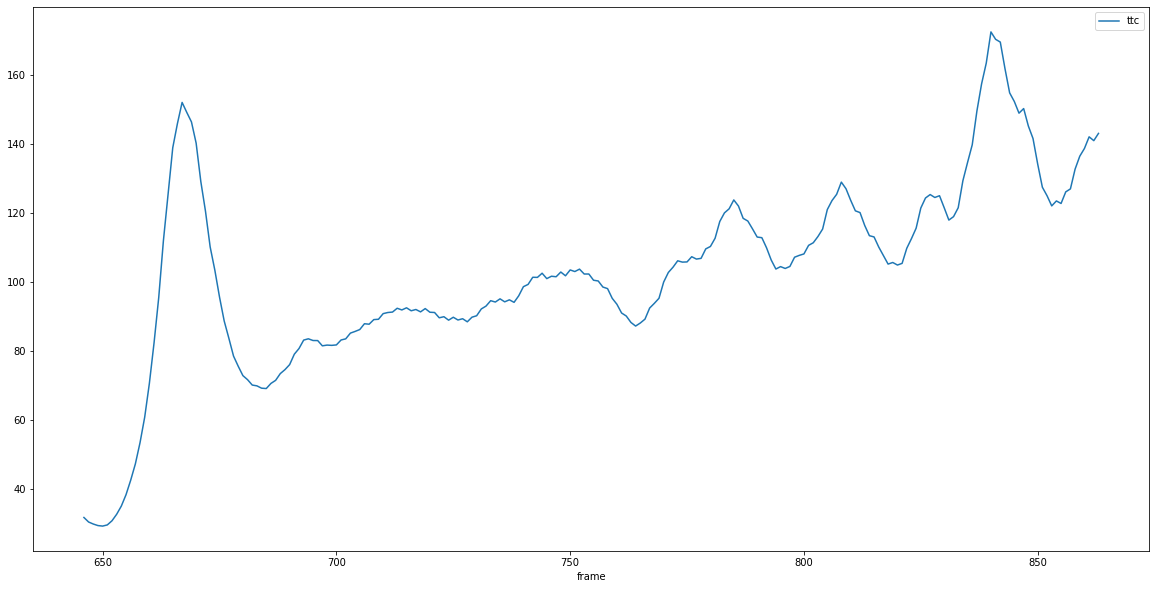

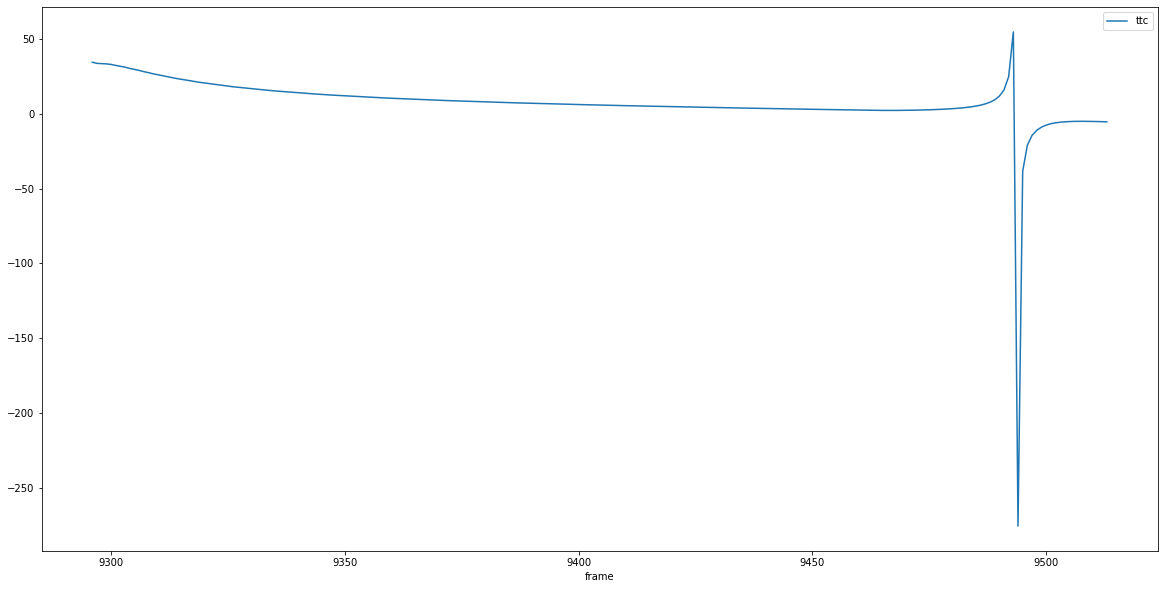

In [15]:
original_df.plot(x='frame', y=['ttc'], figsize=(20, 10))
idm.plot(x='frame', y=['ttc'], figsize=(20, 10))
cogmod.plot(x='frame', y=['ttc'], figsize=(20, 10))

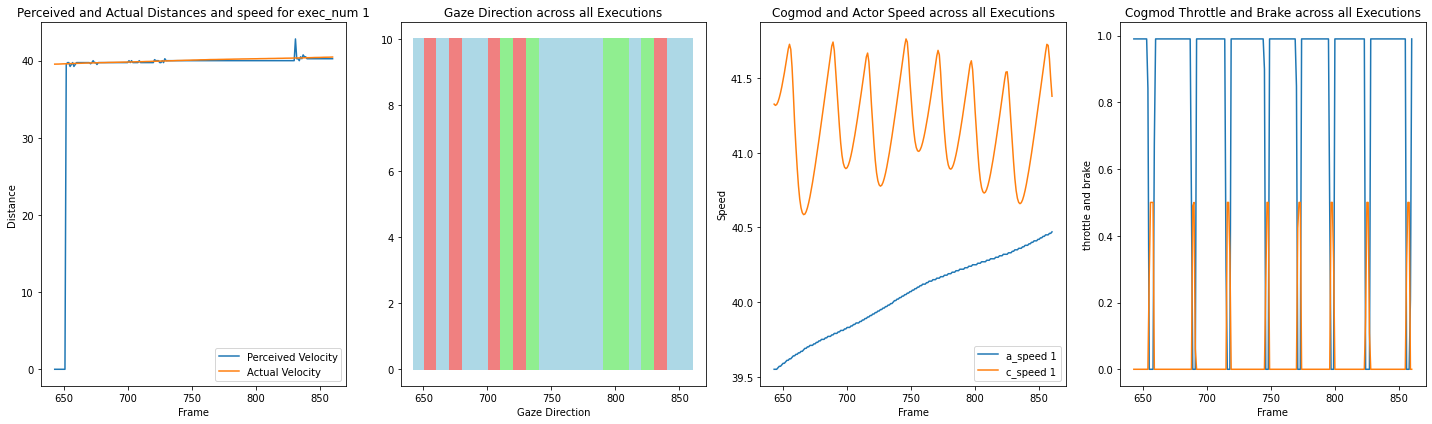

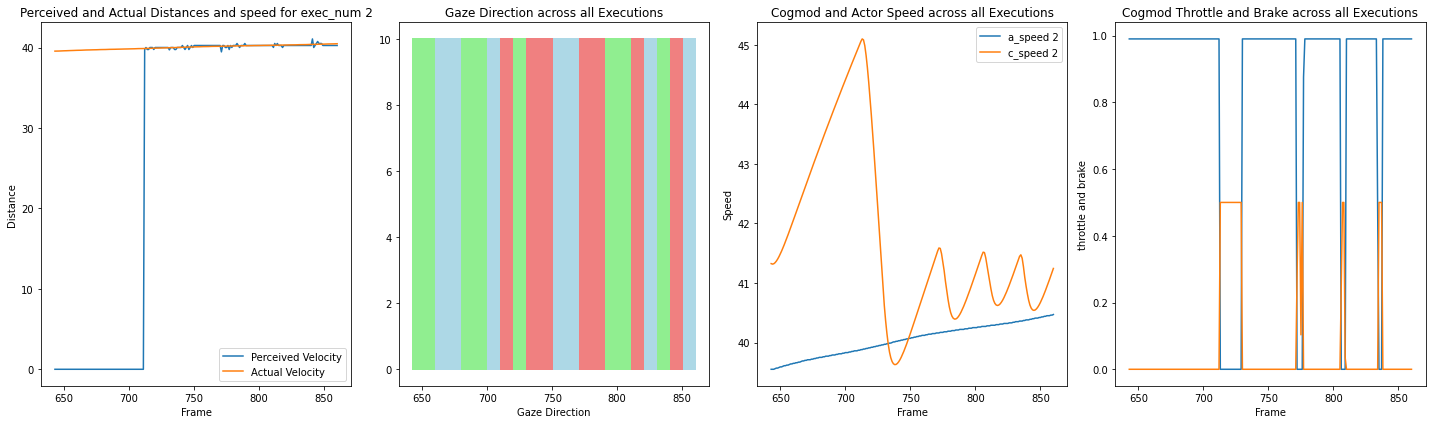

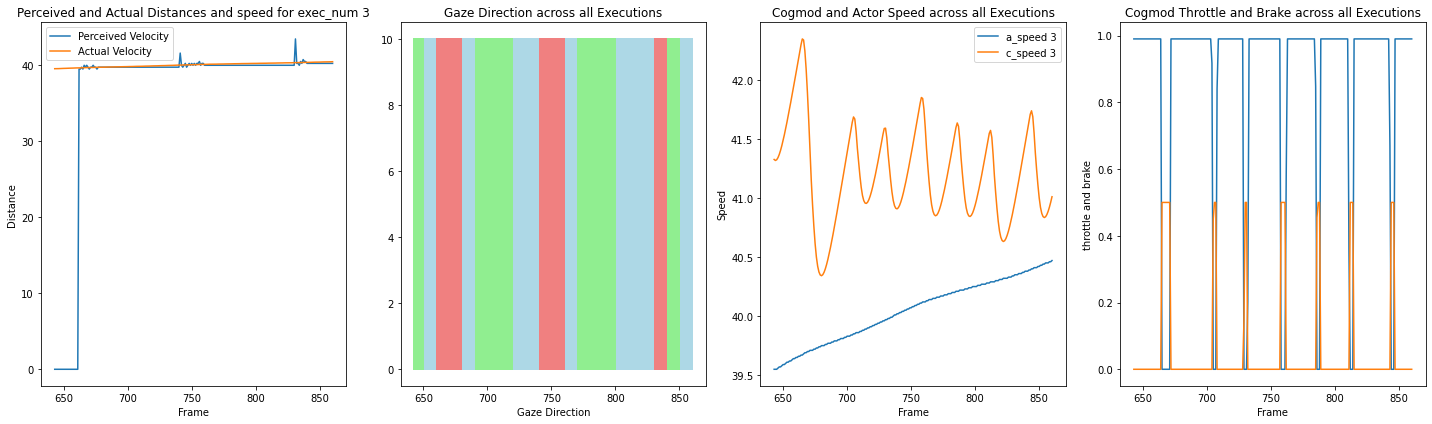

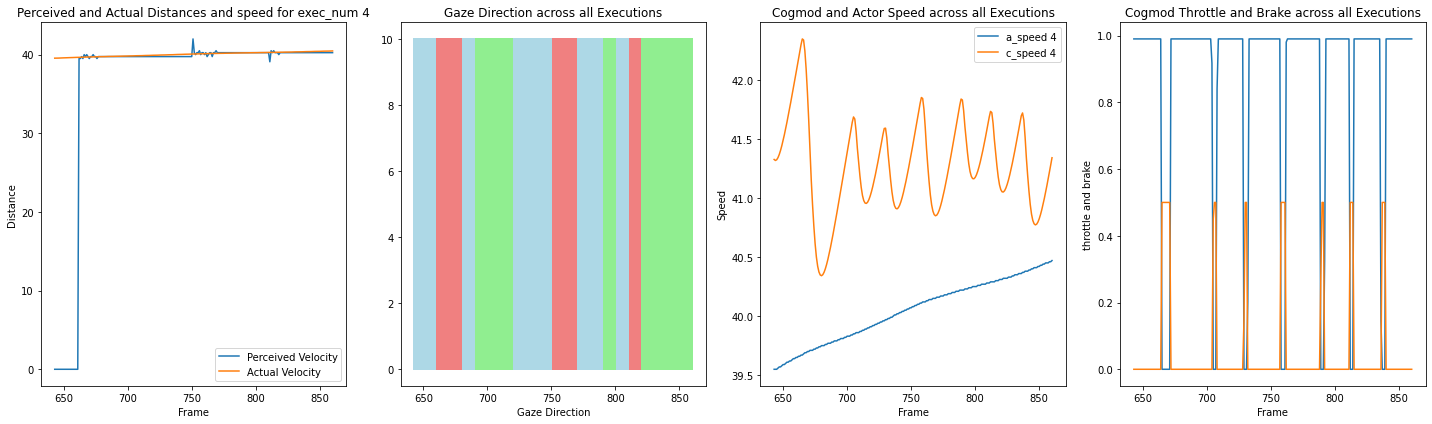

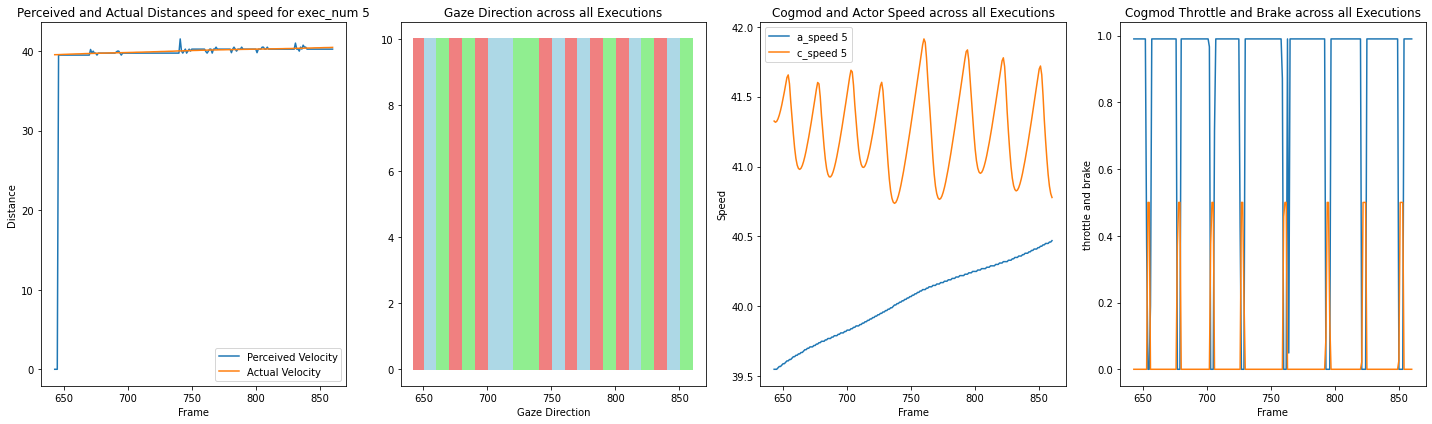

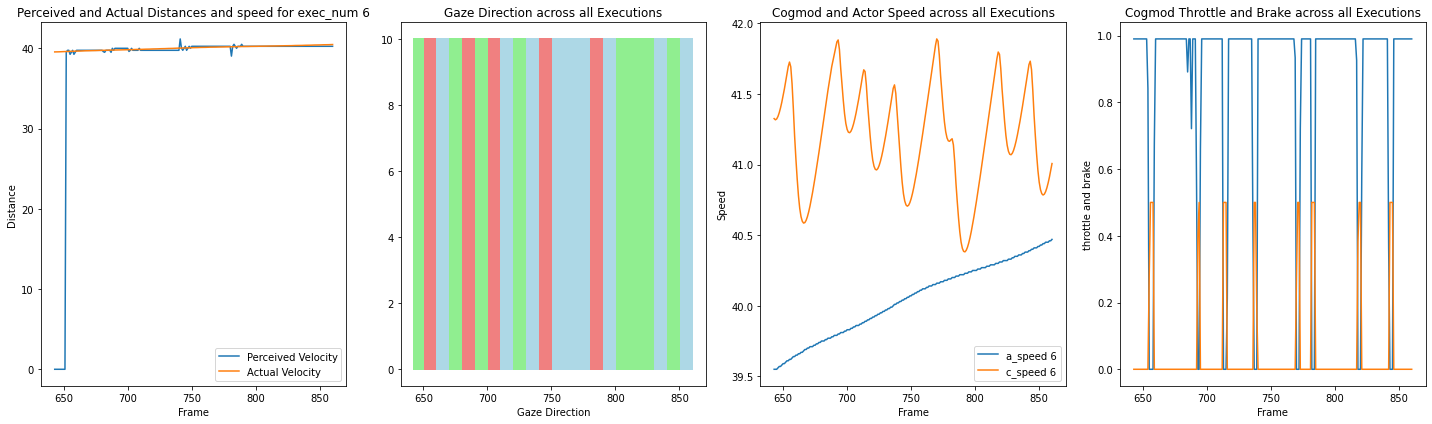

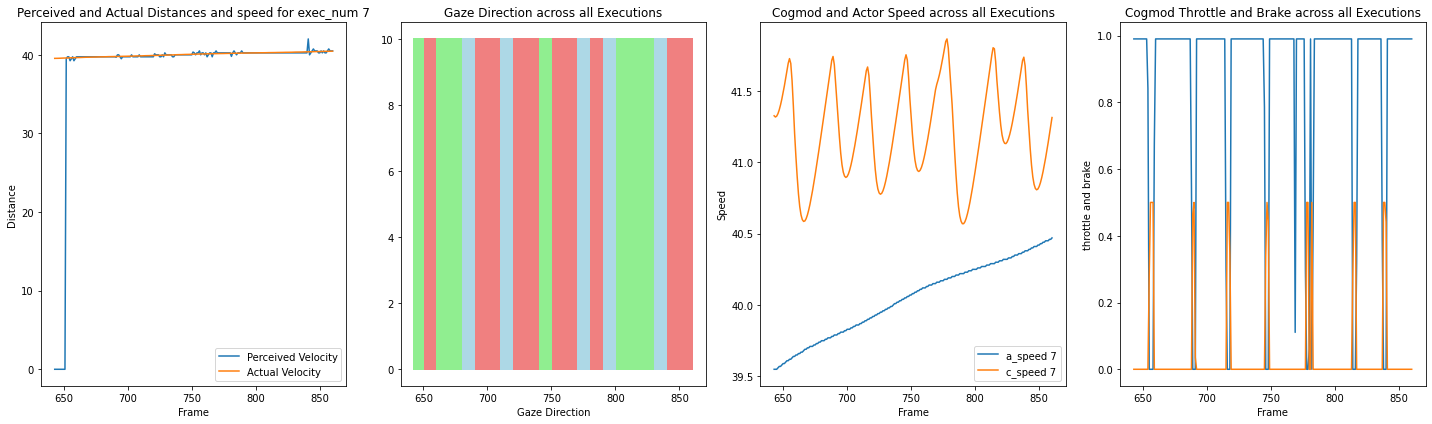

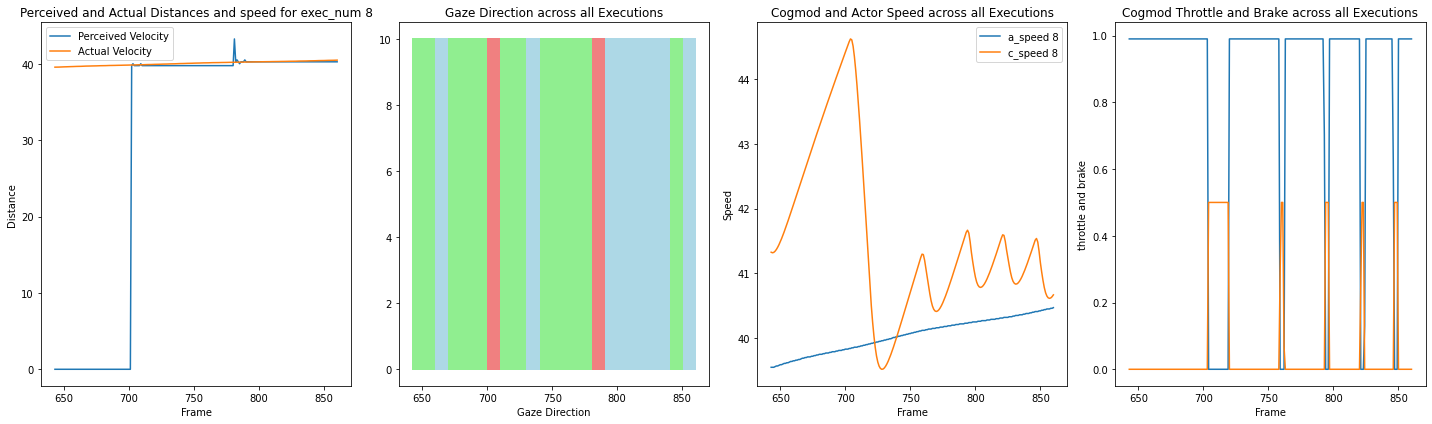

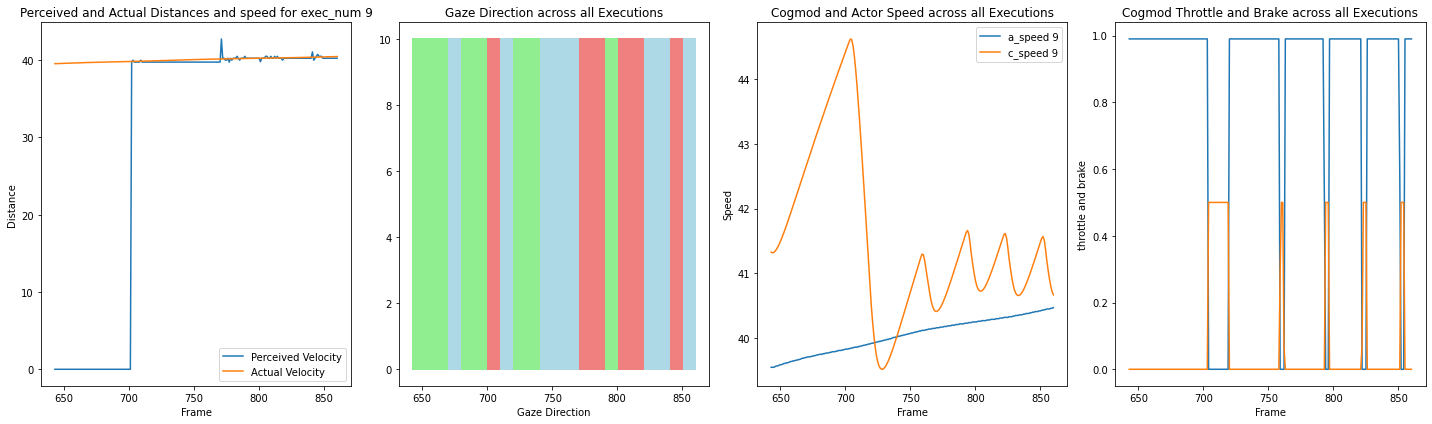

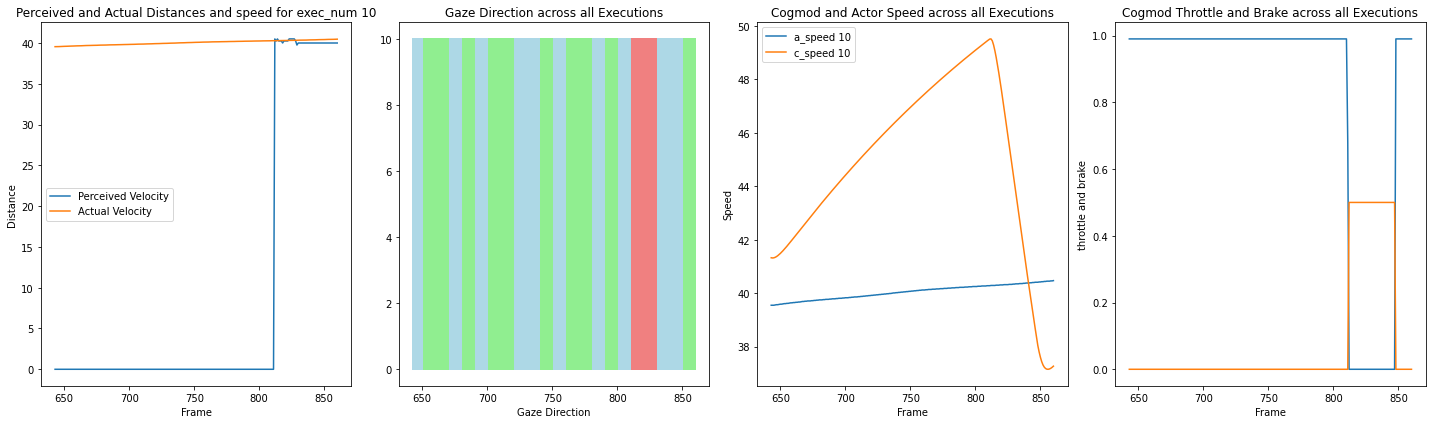

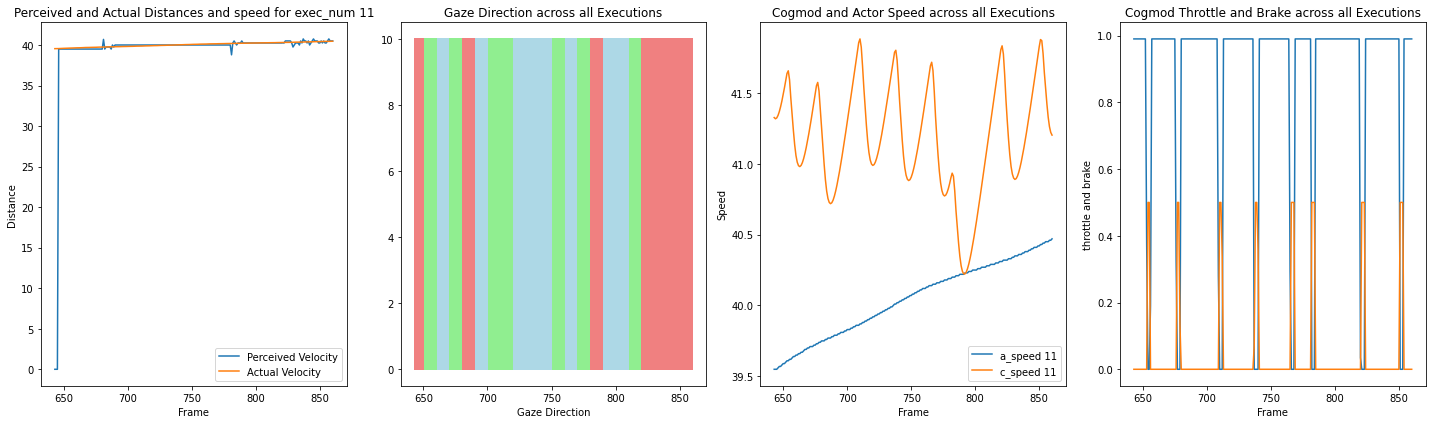

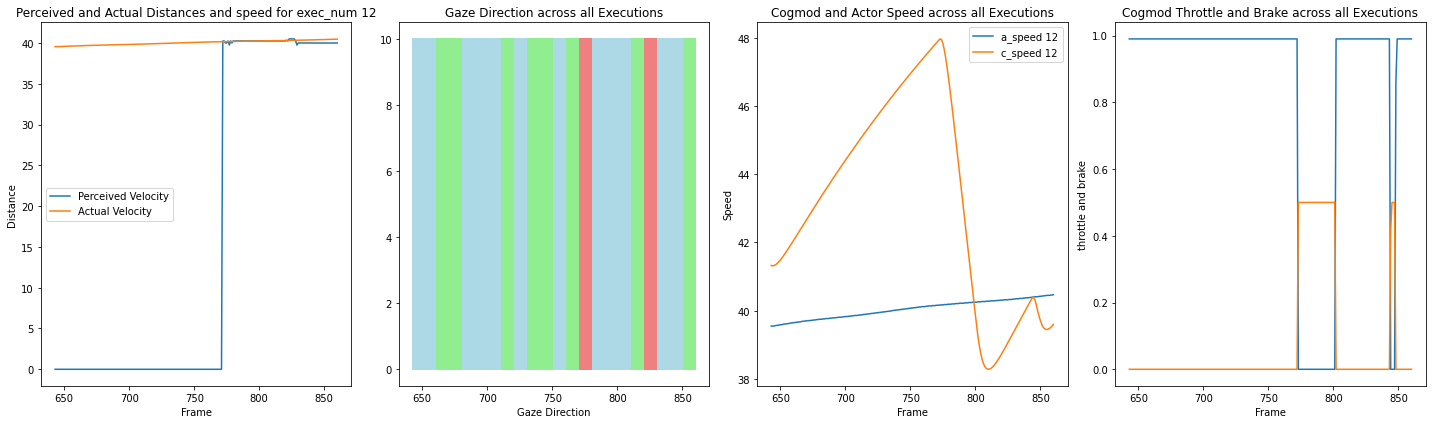

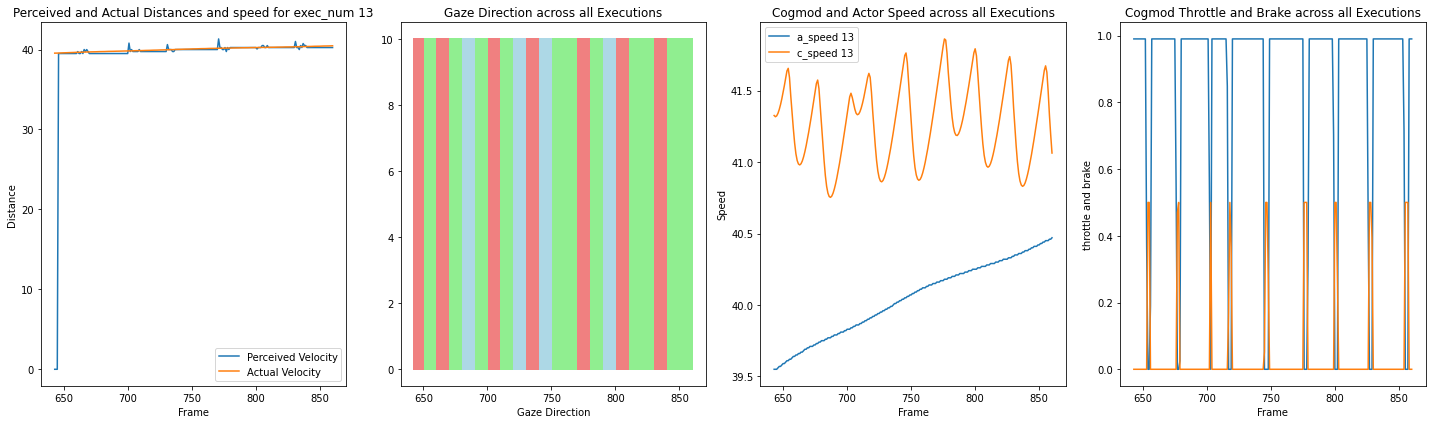

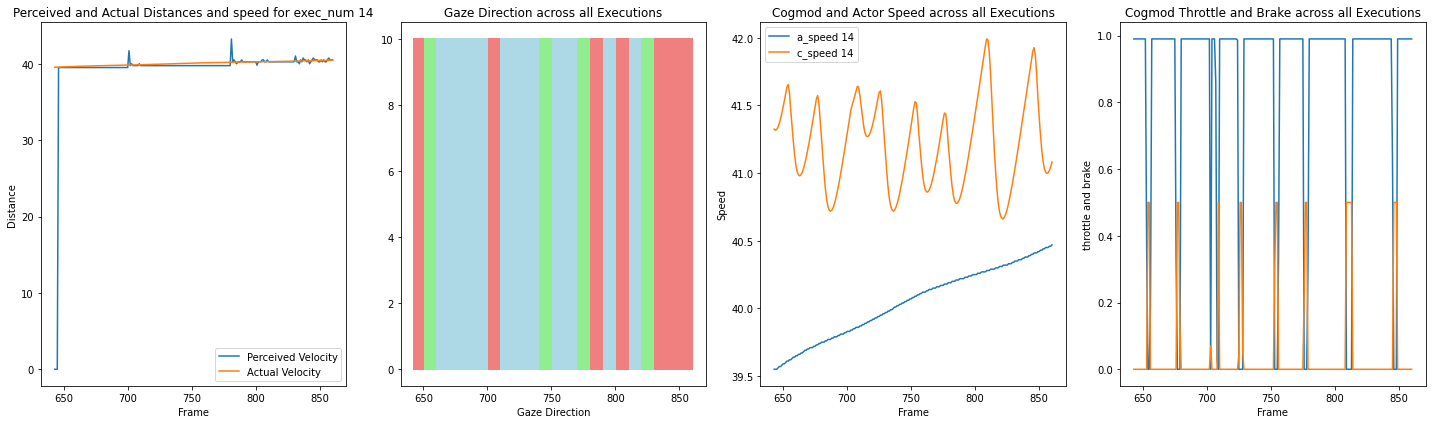

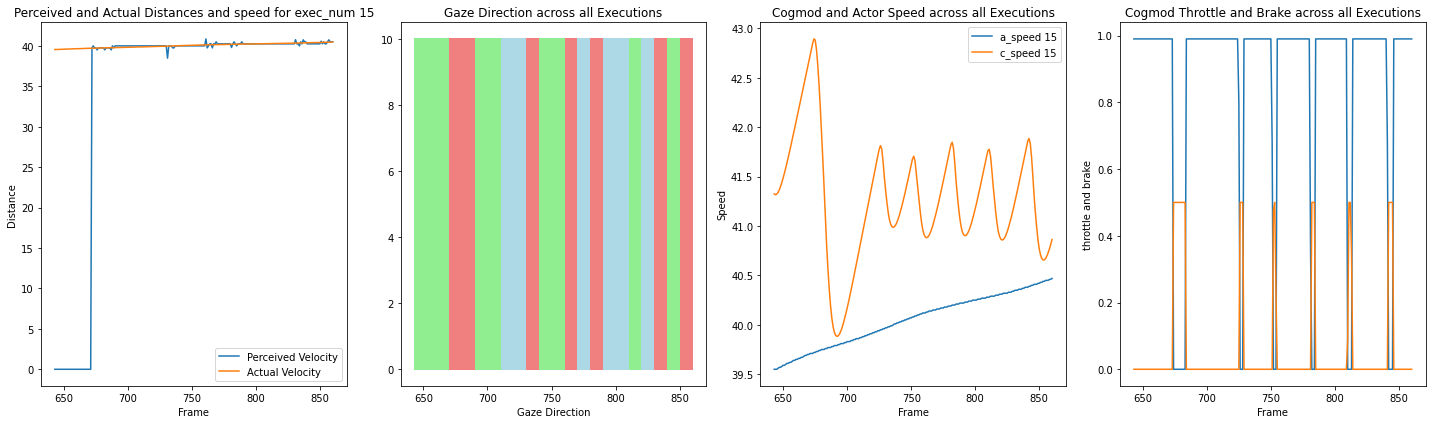

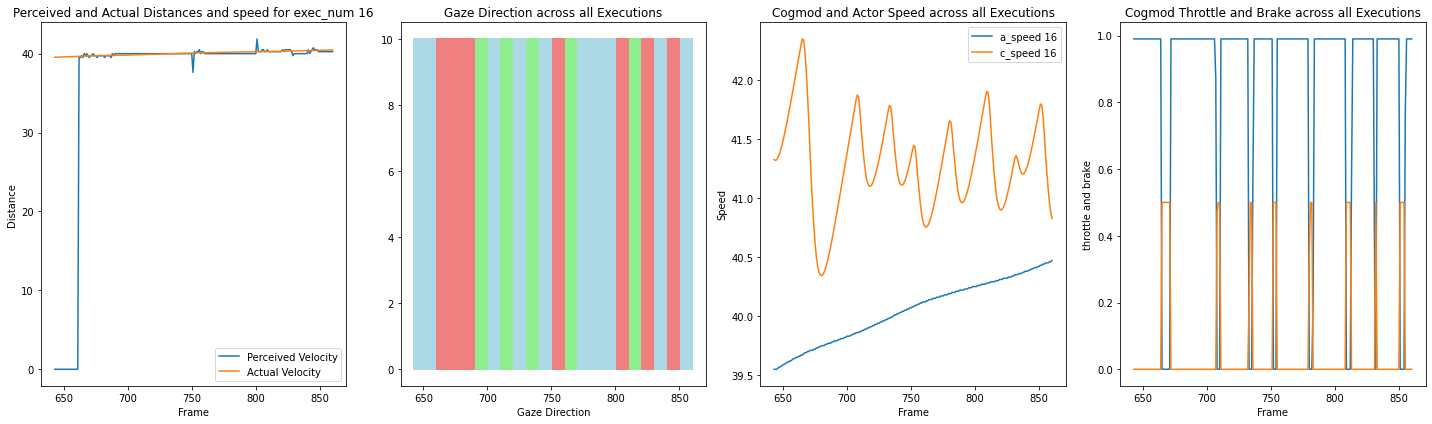

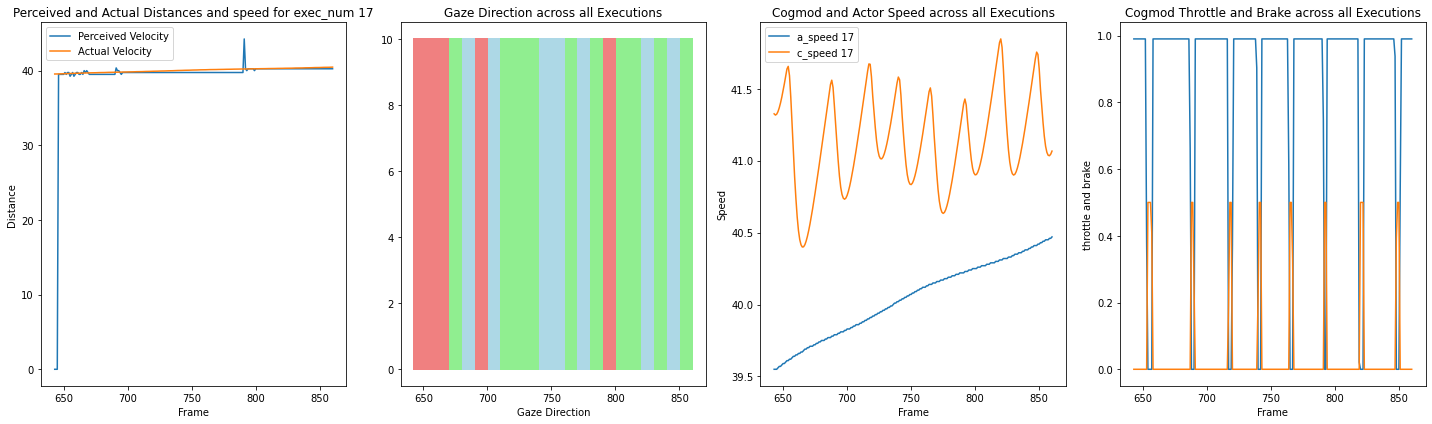

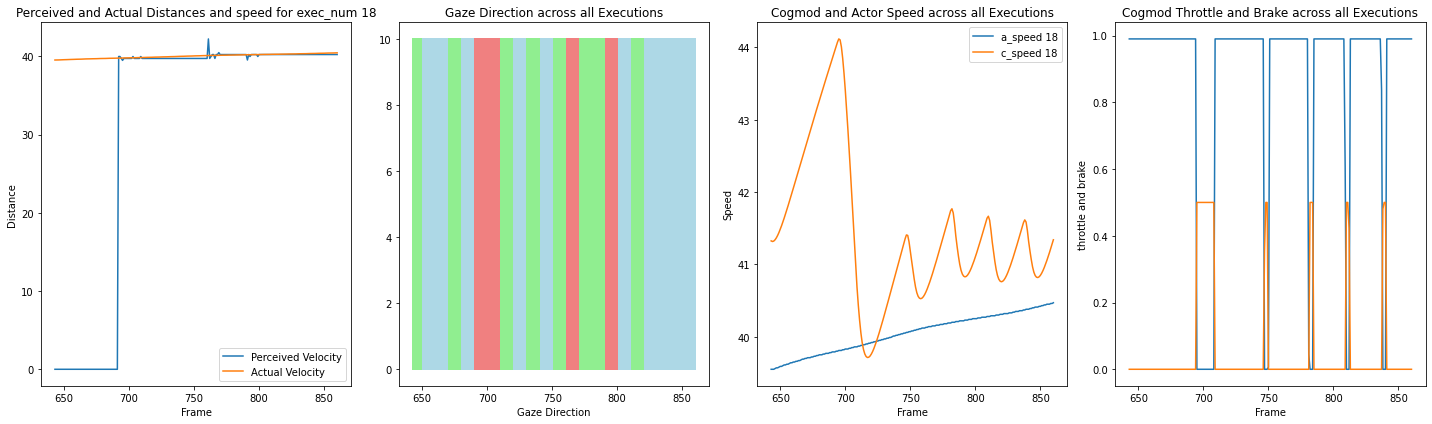

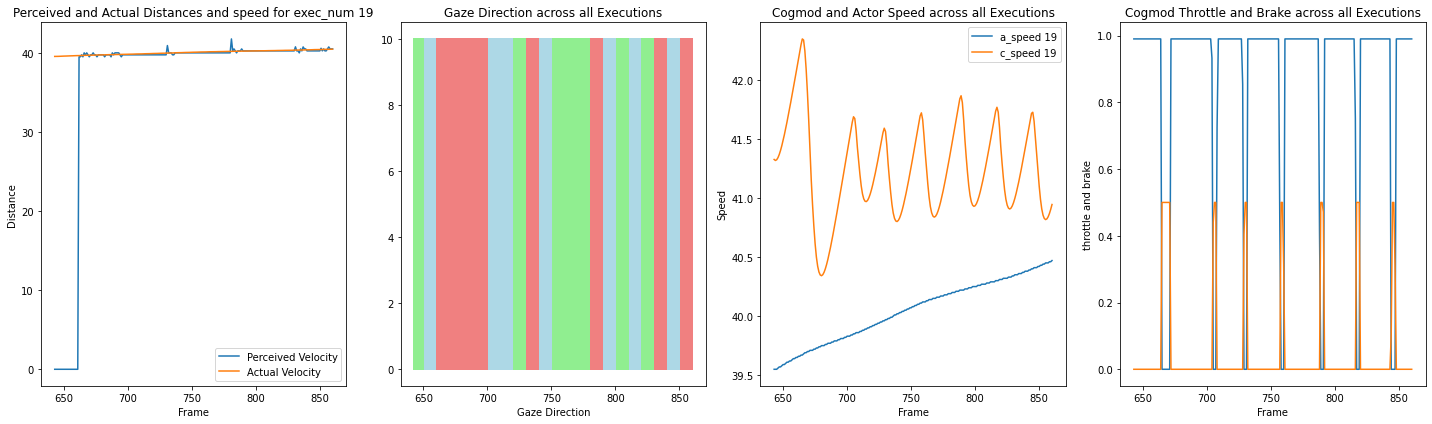

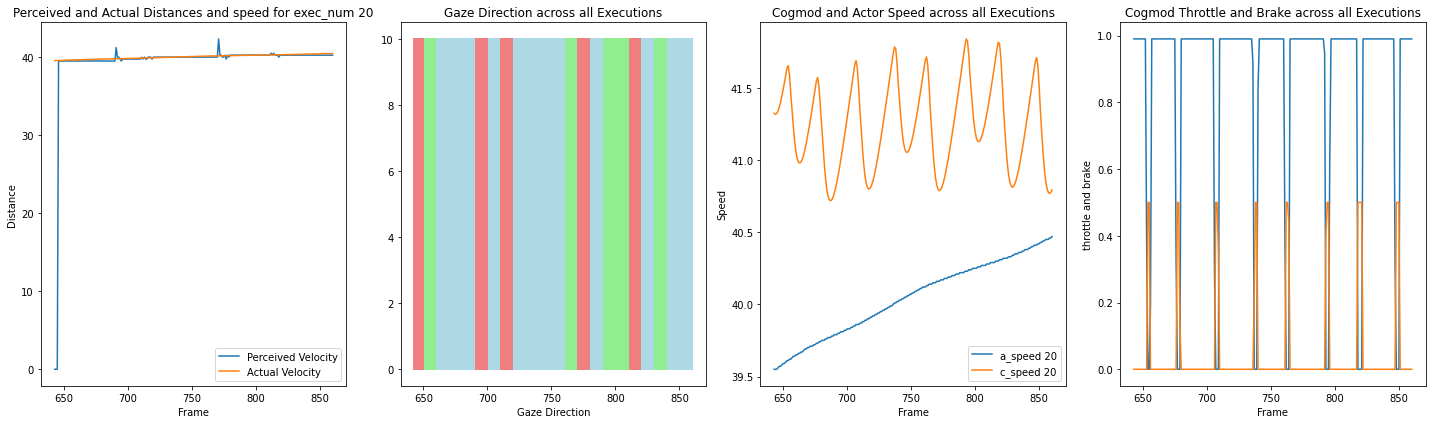

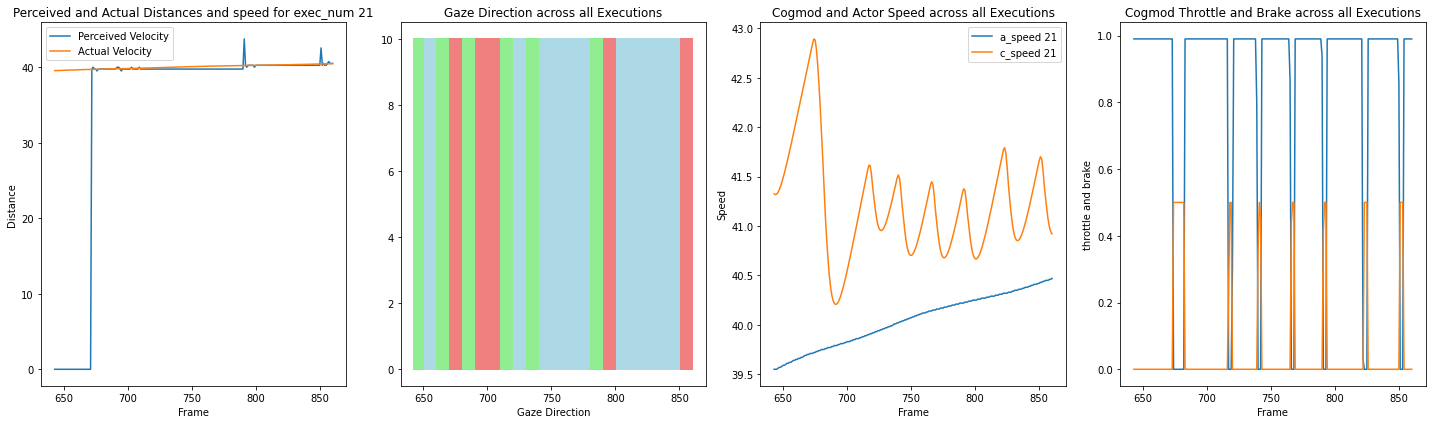

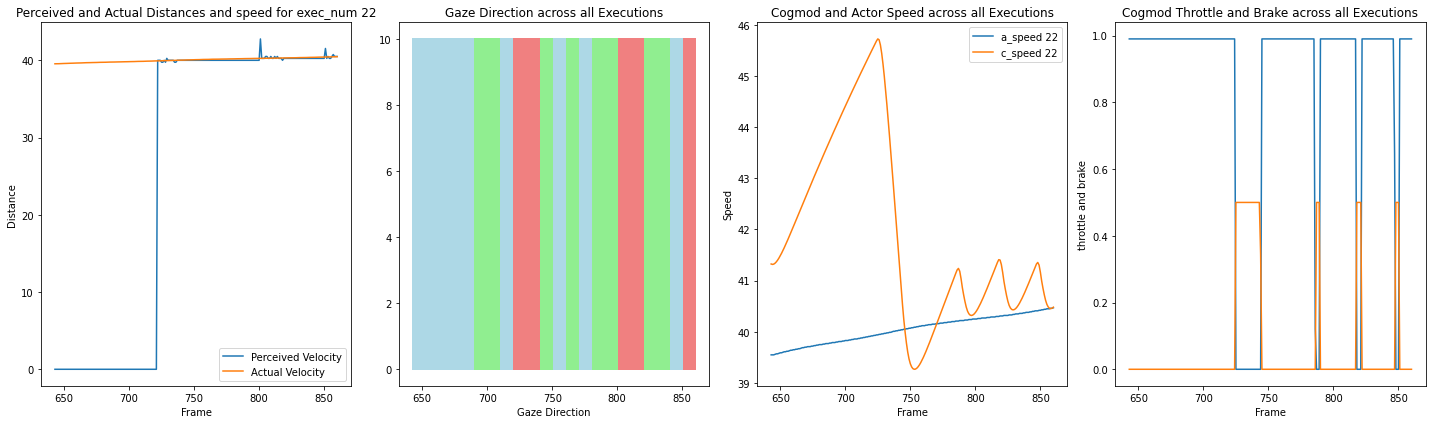

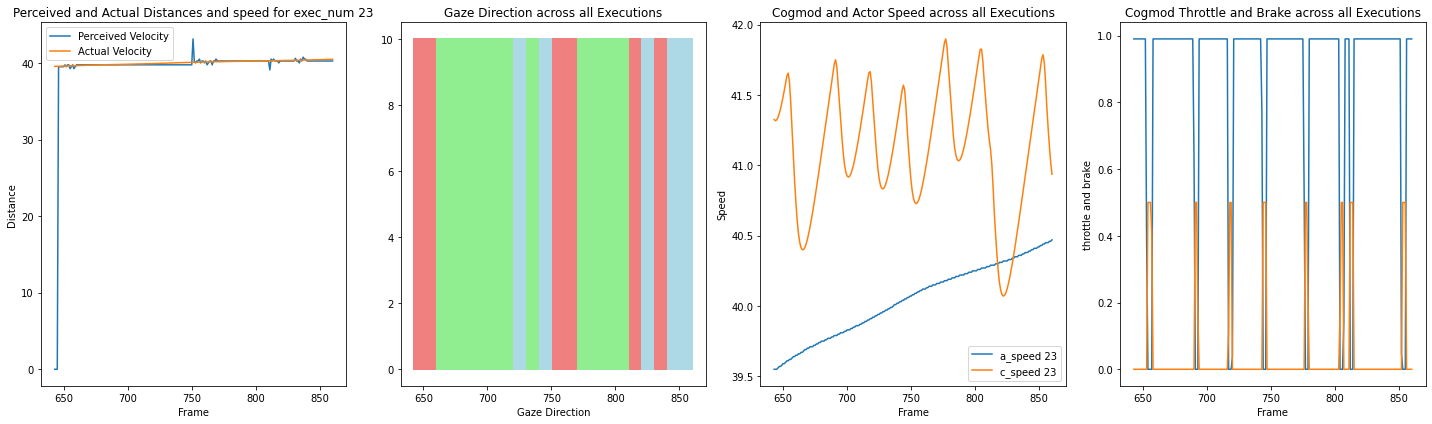

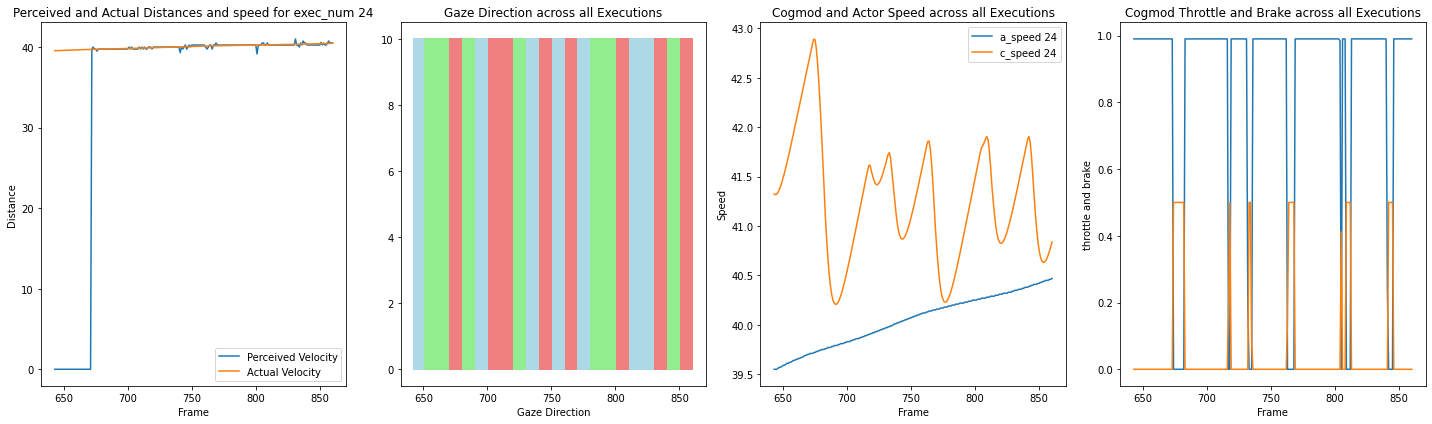

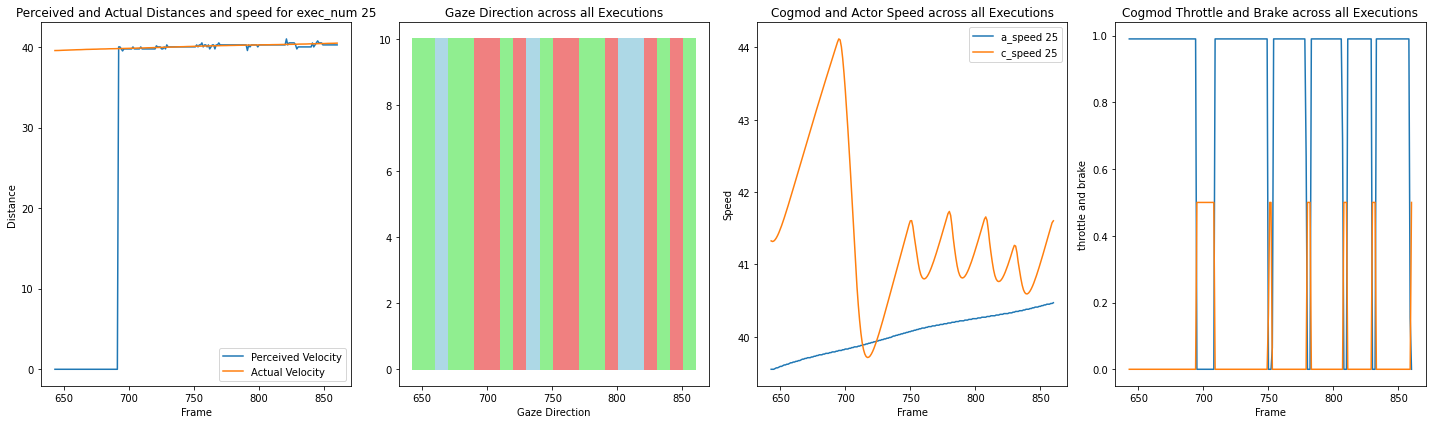

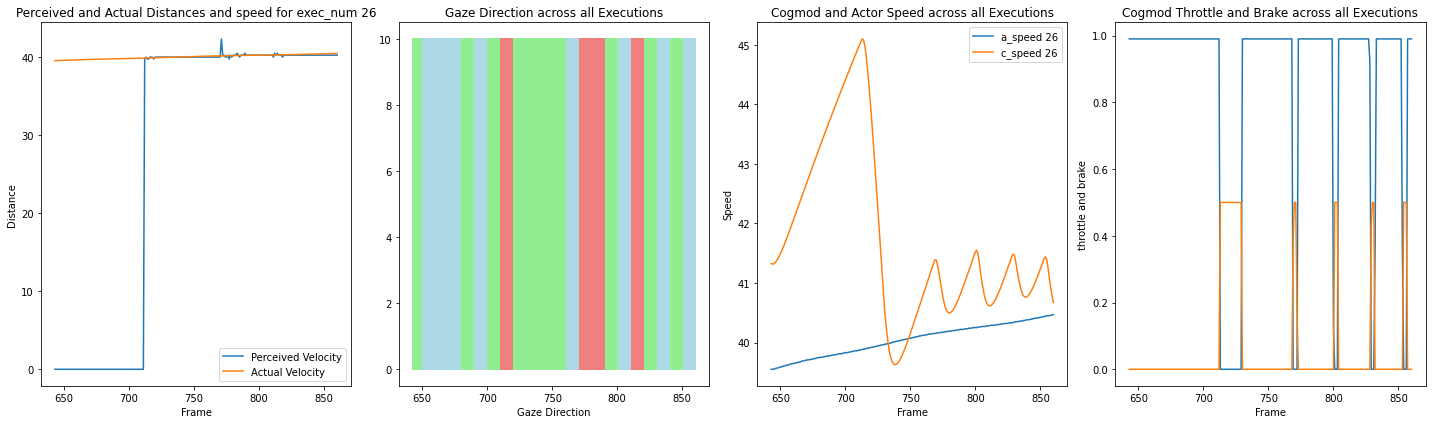

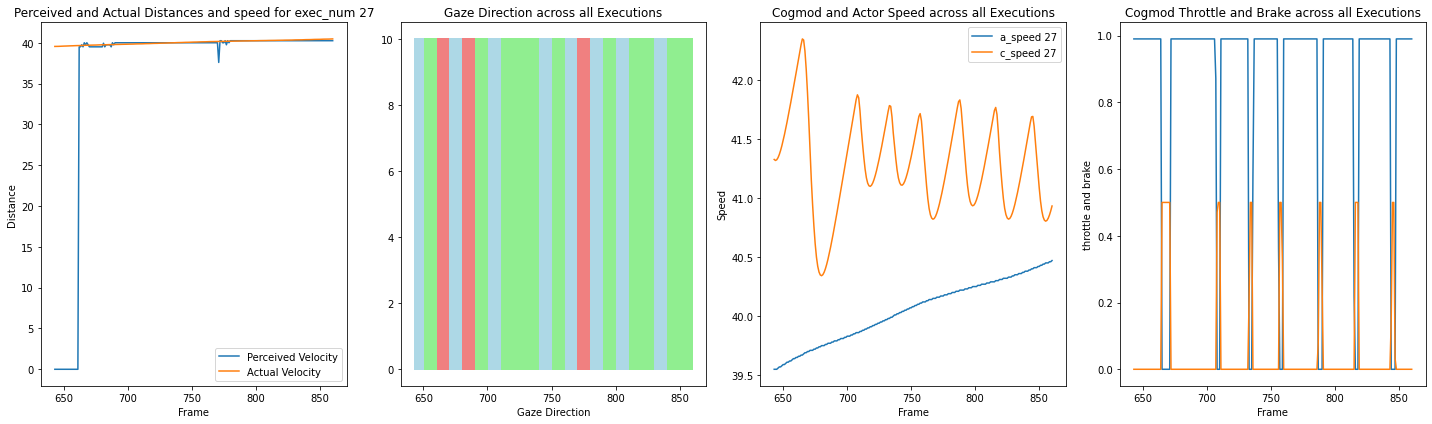

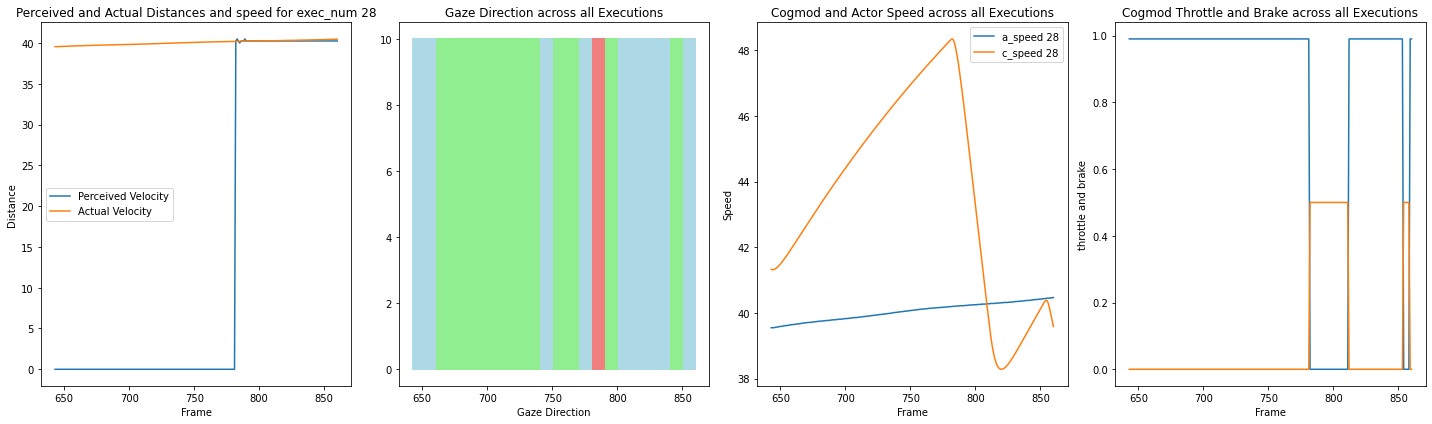

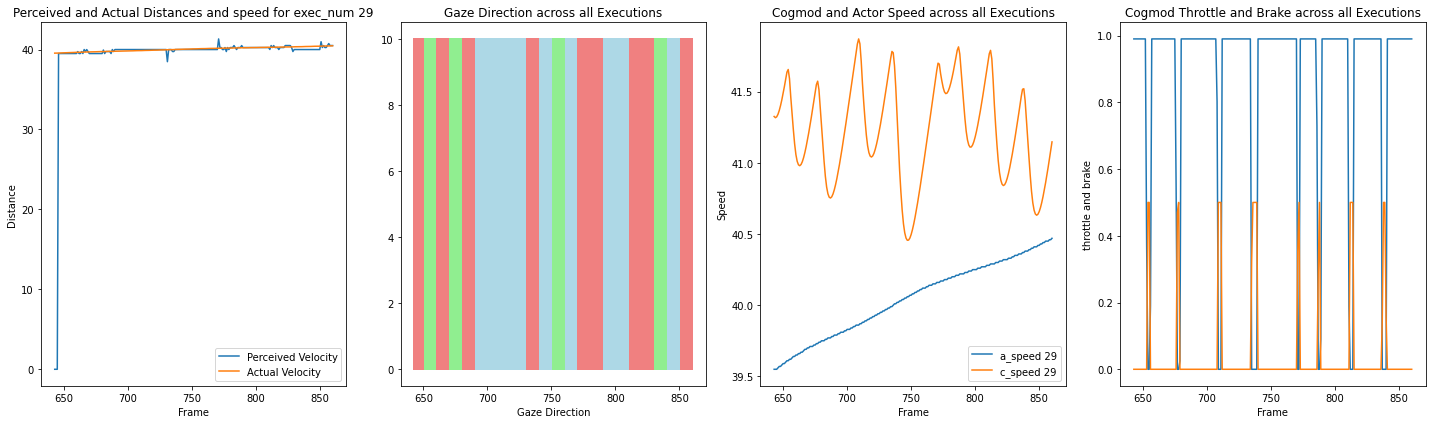

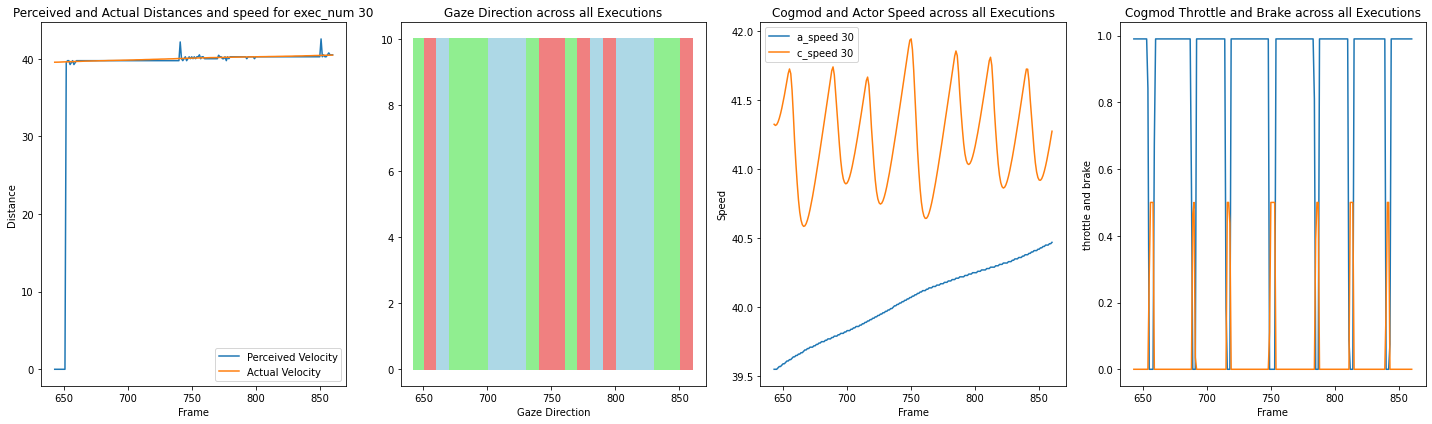

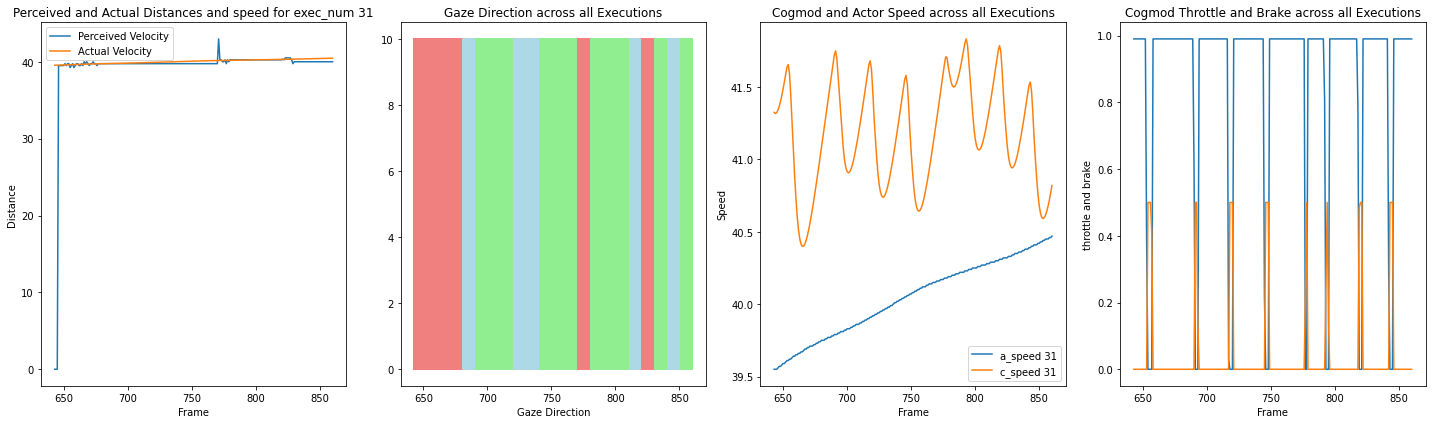

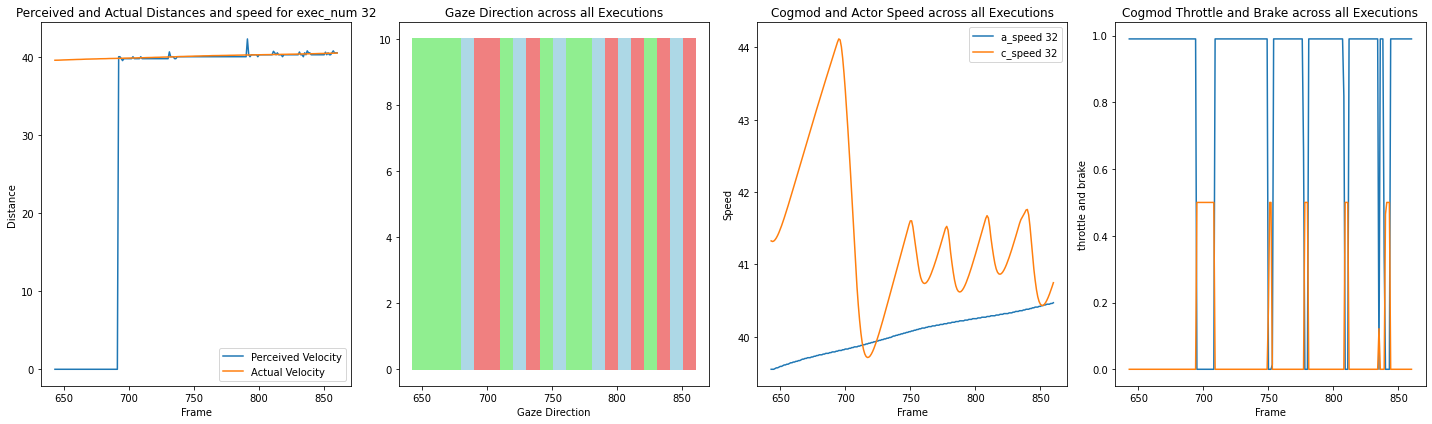

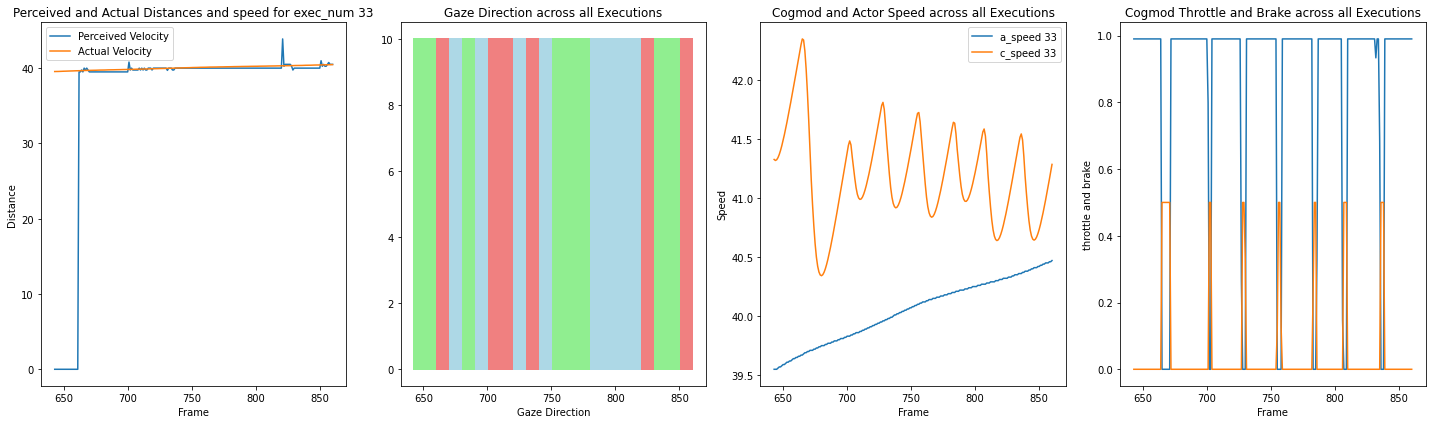

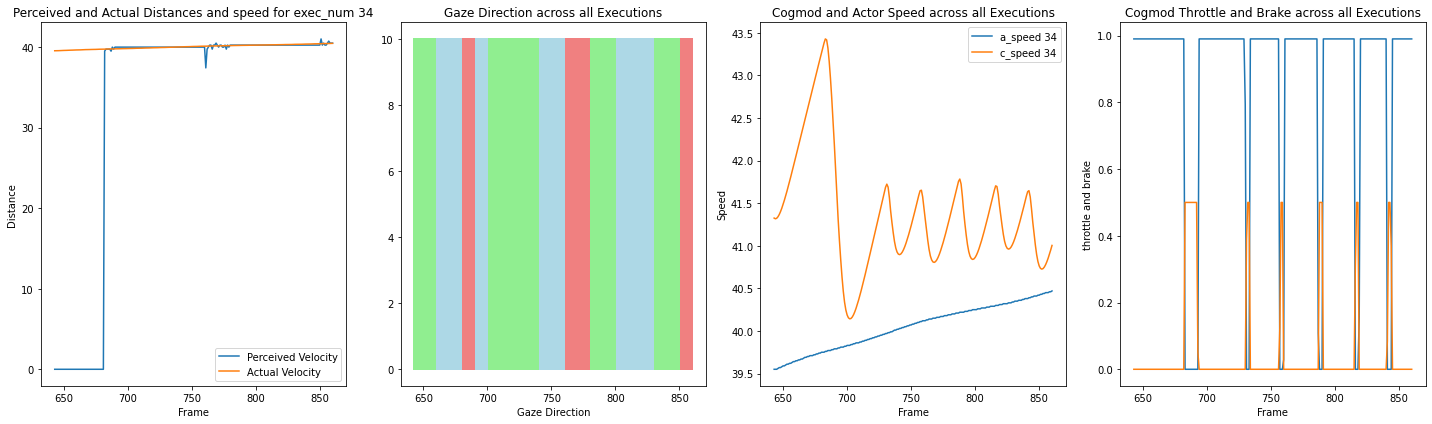

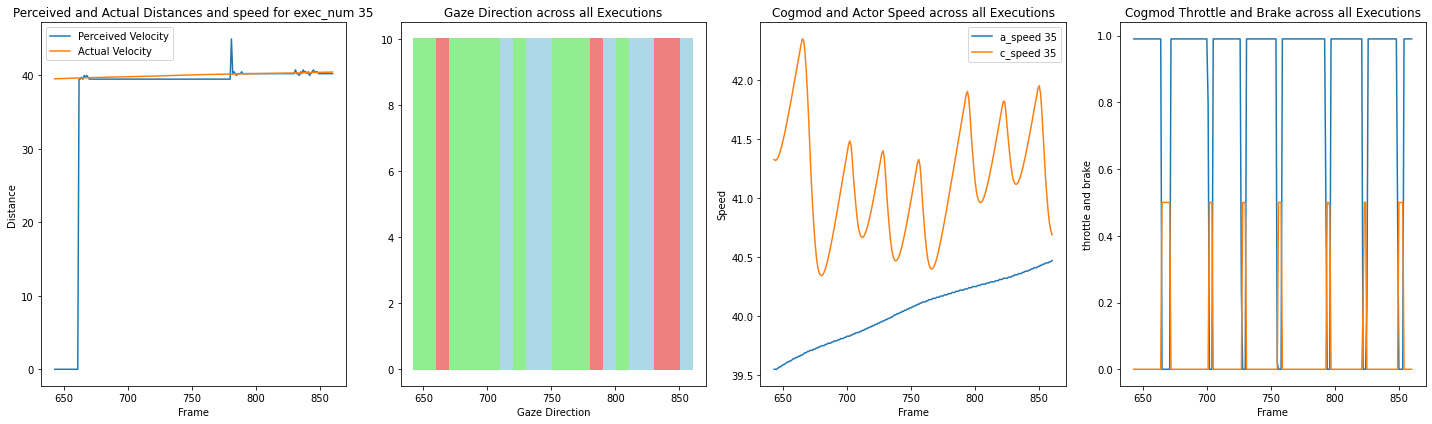

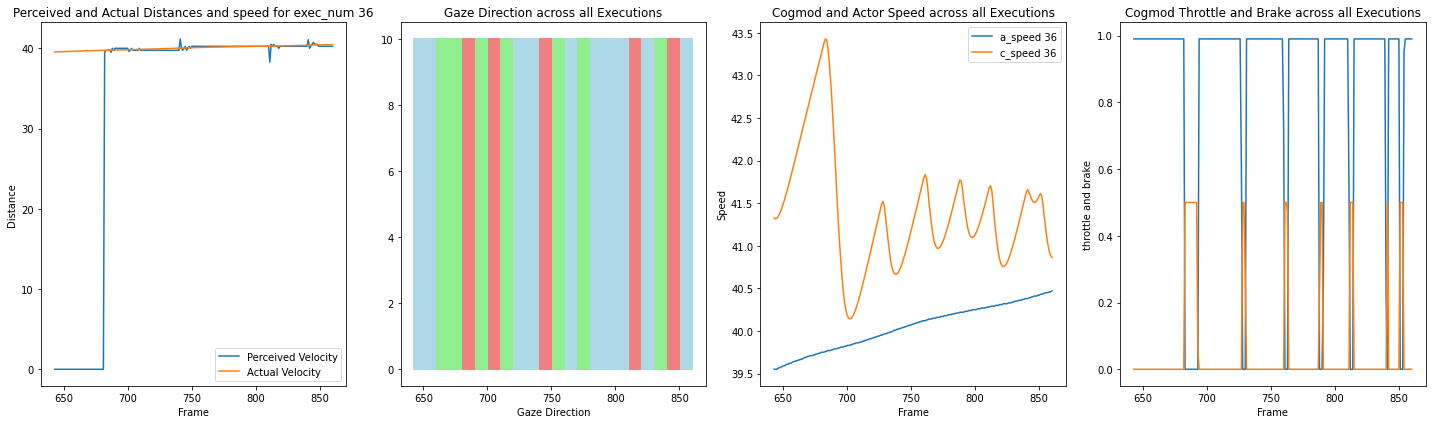

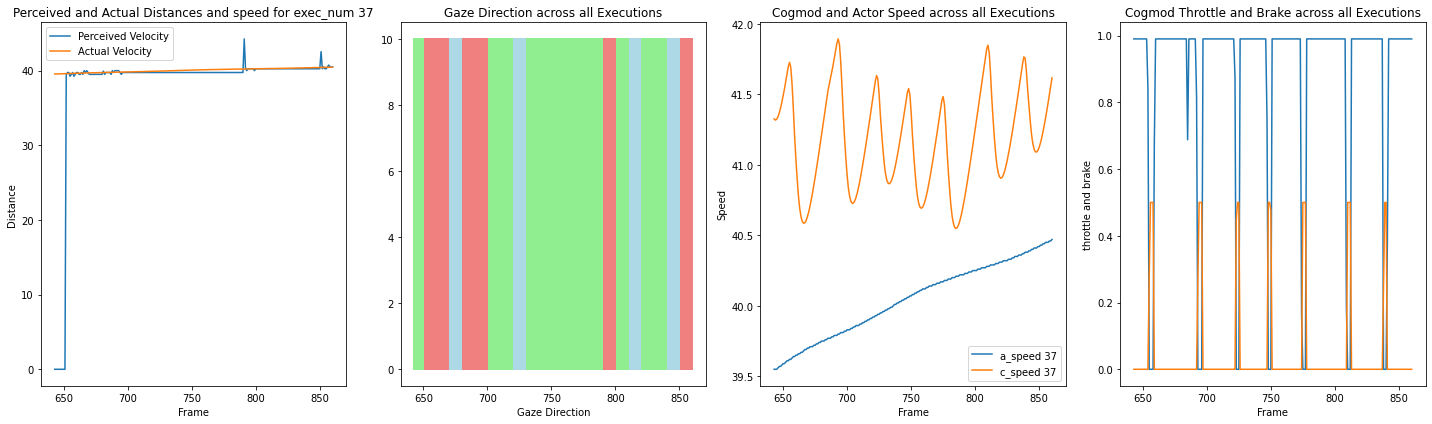

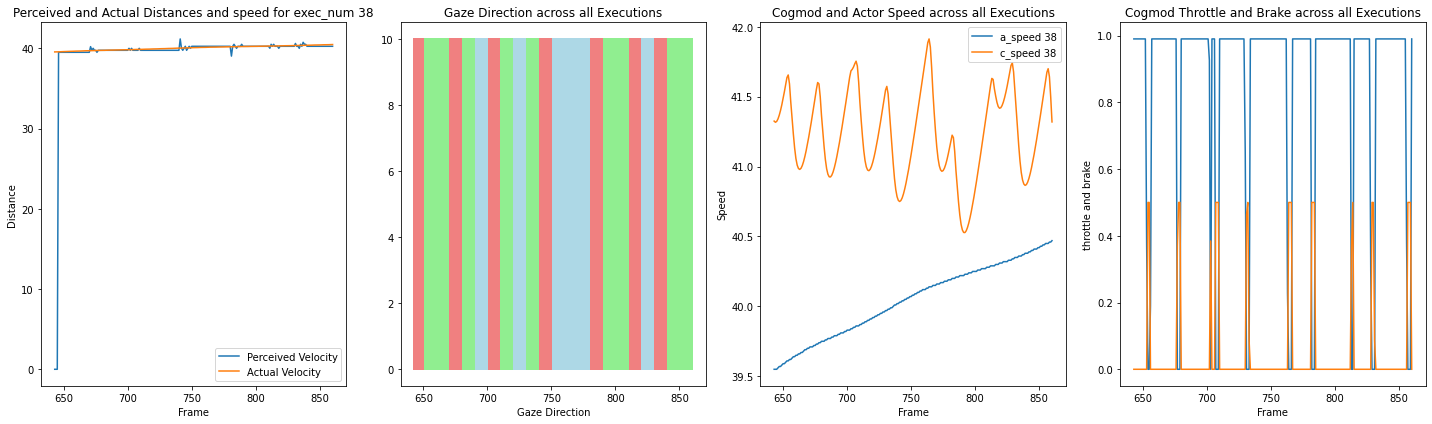

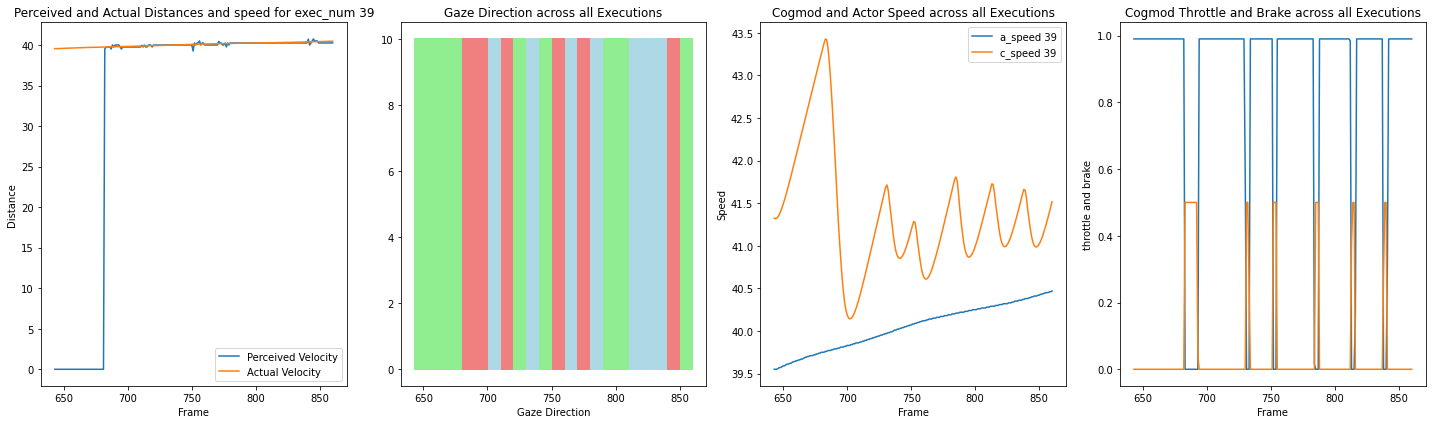

In [16]:
Plot.plot_individual_exec_nums(cogmod_df, only_running = True)

In [17]:
# from scipy.signal import savgol_filter

# # cogmod = cogmod[cogmod['scenario_status'] ==    'ScenarioState.RUNNING']

# cogmod.plot(x='frame', y = 'c_speed')
# new_cogmod = cogmod.copy()
# new_cogmod['c_speed'] = savgol_filter(cogmod['c_speed'], 51, 3)
# new_cogmod.plot(x='frame', y = 'c_speed')
